By MEHRAN KHODADADZADEH GOJEH


Master of Biomedical Engineering- Specialization in Artificial Intelligence

Email : mehrankhodadadzadeh90@gmail.com

Note : To have access the data,you can send me an email.

**Prediction Modeling for Mortality in ICU Patients Suffering from Heart Failure**


#Project Explanation

The goal of the work is to develop a mortality prediction model for patients with heart failure admitted to intensive care units(ICU). The dataset includes 48 features in four categories: demographic characteristics (e.g., age, gender), vital signs (e.g., heart rate, blood pressure), comorbidities (e.g., diabetes, hypertension), and laboratory variables (e.g., blood glucose levels, creatinine levels). These features based on reaserach are chosen for their more relevance to heart failure and ICU patients.The data will be preprocessed to make it suitable for modeling and prediction.

# Data loading

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#the path where my all raw data features placed.
#path='/content/drive/MyDrive/Techniques_of_AI'

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import (precision_score, recall_score, roc_auc_score, roc_curve,
                             accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
                             confusion_matrix, auc, classification_report, cohen_kappa_score)
from xgboost import XGBClassifier
from datetime import datetime
from scipy.stats import shapiro
import xgboost as xgb
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.preprocessing import StandardScaler
#from sklearn.tree import DecisionTreeClassifier

In [ ]:
#to run the code , you can just upload the unziped file to the platform you use(jupyter or google colab) and copy its path here.
path='/content/'

#preprocessing of Demographic Characteristics

In [ ]:
def reading_data (filename):
    file_path = os.path.join(path, filename)
    return pd.read_csv(file_path)

In [ ]:
#file where the personal general information of patients are located in 'hadm_records''.
patients = reading_data('hadm_records.csv')

patients.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,ETHNICITY,DOB,EXPIRE_FLAG,ADMITTIME,LOS
0,56,181711,275642,F,WHITE,1804-01-02 00:00:00,1,2104-01-02 02:01:00,1.8492
1,25147,106000,277318,F,WHITE,2059-08-18 00:00:00,1,2128-01-11 17:02:00,4.9646
2,17863,148295,205992,F,WHITE,2062-11-13 00:00:00,1,2144-01-28 20:18:00,18.2774
3,19267,117996,213557,F,WHITE,2107-08-19 00:00:00,1,2188-02-22 16:28:00,2.0126
4,19334,183582,275392,F,PATIENT DECLINED TO ANSWER,2041-06-11 00:00:00,1,2102-12-26 13:48:00,5.0944


In [ ]:
print(patients.shape)

(15277, 9)


In [ ]:
#unnecessary information columns named:'ICUSTAY_ID' and 'LOS' has been removed
patients = patients.loc[:, patients.columns.drop(['ICUSTAY_ID', 'LOS'])]

# Remove repeatitve info in patients Ids.
patients = patients.drop_duplicates(['HADM_ID'])

patients.head()

,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,DOB,EXPIRE_FLAG,ADMITTIME
0,56,181711,F,WHITE,1804-01-02 00:00:00,1,2104-01-02 02:01:00
1,25147,106000,F,WHITE,2059-08-18 00:00:00,1,2128-01-11 17:02:00
2,17863,148295,F,WHITE,2062-11-13 00:00:00,1,2144-01-28 20:18:00
3,19267,117996,F,WHITE,2107-08-19 00:00:00,1,2188-02-22 16:28:00
4,19334,183582,F,PATIENT DECLINED TO ANSWER,2041-06-11 00:00:00,1,2102-12-26 13:48:00


In [ ]:
print(patients.shape)

(13863, 7)


In [ ]:
#for having numerical simple value I calculated age from the date of birth and admission time.
def age_f(born, adm):
    born = datetime.strptime(born.replace('-','/'), '%Y/%m/%d %H:%M:%S')
    adm = datetime.strptime(adm.replace('-','/'), '%Y/%m/%d %H:%M:%S')
    return adm.year - born.year - ((adm.month, adm.day) < (born.month, born.day))

# appling age f in loop to measure the age for all patients
dob = patients['DOB'].tolist()
admision_time = patients['ADMITTIME'].tolist()
age = [age_f(dob[i], admision_time[i]) for i in range(len(dob))]

In [ ]:
#now removig the 'DOB' and 'ADMITTIME'columns and adding the age calculated in prev step.
patients = patients.loc[:, patients.columns.drop(['DOB', 'ADMITTIME'])]
patients.insert(4, 'AGE', age)

patients.head()



,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,AGE,EXPIRE_FLAG
0,56,181711,F,WHITE,300,1
1,25147,106000,F,WHITE,68,1
2,17863,148295,F,WHITE,81,1
3,19267,117996,F,WHITE,80,1
4,19334,183582,F,PATIENT DECLINED TO ANSWER,61,1


there is a problem in the data set as we can see some age calculations are bigger than normal. so there is a need to put a threshold.

In [ ]:
patients_info = patients[patients.AGE <= 100]
patients_info.head()


,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,AGE,EXPIRE_FLAG
1,25147,106000,F,WHITE,68,1
2,17863,148295,F,WHITE,81,1
3,19267,117996,F,WHITE,80,1
4,19334,183582,F,PATIENT DECLINED TO ANSWER,61,1
5,19334,155858,F,PATIENT DECLINED TO ANSWER,60,1


In [ ]:
print(patients_info.shape)

(12517, 6)


# preprocessing of Comorbidities

In [ ]:
patients_diseases = reading_data('comorbidities.csv')
patients_diseases.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,DOB,EXPIRE_FLAG,LOS,hypertension,atrial_fibrillation,ischaemic_heart_disease,diabetes_mellitus,depression,hypoferric_anaemia,hyperlipidaemia,chronic_kidney_disease,chronic_obstructive_pulmonary_disease
0,768,170167,216049,F,2109-04-15 00:00:00,1,2.9181,0,1,0,0,0,0,1,0,1
1,67072,131177,269189,F,2130-06-29 00:00:00,0,2.0349,1,0,0,0,0,0,0,0,0
2,3840,166081,270094,M,2062-03-31 00:00:00,1,3.3035,0,1,1,0,0,0,0,0,1
3,4096,124383,201361,M,2091-09-11 00:00:00,0,2.1430,1,1,0,1,0,0,0,0,1
4,4096,161677,227656,M,2091-09-11 00:00:00,0,1.0524,1,0,0,1,0,0,1,0,0


In [ ]:
print(patients_diseases.shape)

(15289, 16)


In [ ]:

patients_diseases = patients_diseases.loc[:, patients_diseases.columns.drop(['SUBJECT_ID', 'ICUSTAY_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG', 'LOS'])]
patients_diseases = patients_diseases.drop_duplicates()


patients_diseases.head()



,HADM_ID,hypertension,atrial_fibrillation,ischaemic_heart_disease,diabetes_mellitus,depression,hypoferric_anaemia,hyperlipidaemia,chronic_kidney_disease,chronic_obstructive_pulmonary_disease
0,170167,0,1,0,0,0,0,1,0,1
1,131177,1,0,0,0,0,0,0,0,0
2,166081,0,1,1,0,0,0,0,0,1
3,124383,1,1,0,1,0,0,0,0,1
4,161677,1,0,0,1,0,0,1,0,0


In [ ]:

print(patients_diseases.shape)

(13874, 10)


As you can see there are 9 possible diseases for each patients idis that some of them have one or more than that with value of 1 .

# preprocessing vital signs and lab variabales -> feature units modifications


In [ ]:
#my features
features = [


    'heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'mean_blood_pressure',
    'respiratory_rate', 'saturation_pulse_oxygen', 'body_temperature', 'Red_Blood_Cells', 'MCH',
    'MCHC', 'MCV', 'RDW', 'Neutrophils', 'Basophils', 'Hematocrit', 'Platelet_Count', 'White_Blood_Cells',
    'lymphocytes', 'prothrombin_time', 'international_normalised_ratio', 'NT-proBNP', 'creatine_kinase',
    'creatinine', 'potassium', 'sodium', 'calcium', 'chloride', 'magnesium', 'the_anion_gap', 'bicarbonate',
    'lactate', 'pH', 'partial_pressure_CO2_in_arterial_blood'

]


#vital signs and labratory of patients data
def load_data(path, features):
    data = {}
    for feature in features:
        file_path = f"{path}/{feature}.csv"
        data[feature] = pd.read_csv(file_path)
    return data

data = load_data(path, features)
#all features I am gonna use for preprocessing
print("Loaded features:", list(data.keys()))

Loaded features: ['heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'mean_blood_pressure', 'respiratory_rate', 'saturation_pulse_oxygen', 'body_temperature', 'Red_Blood_Cells', 'MCH', 'MCHC', 'MCV', 'RDW', 'Neutrophils', 'Basophils', 'Hematocrit', 'Platelet_Count', 'White_Blood_Cells', 'lymphocytes', 'prothrombin_time', 'international_normalised_ratio', 'NT-proBNP', 'creatine_kinase', 'creatinine', 'potassium', 'sodium', 'calcium', 'chloride', 'magnesium', 'the_anion_gap', 'bicarbonate', 'lactate', 'pH', 'partial_pressure_CO2_in_arterial_blood']


In [ ]:
def csv_reading(file):

    return pd.read_csv(file)



In [ ]:

vital_lab = [csv_reading(f"{path}/{feature}.csv") for feature in features]

In [ ]:
# Extract unit, to include it in the feature's column name
#removing null entries and taking the first non-null and if the VALUEUOM is missing or empty,I put 'null'.
feature_units_defined = []
for df in vital_lab:
    try:
        UOM = df["VALUEUOM"].dropna().iloc[0]
    except (KeyError, IndexError):
        UOM = 'null'
    feature_units_defined.append(UOM)

# Add name with unit to the column titles of datasets
feature_with_unit = [f"{feature}, {unit}" for feature, unit in zip(features, feature_units_defined)]

print(feature_with_unit)
print({len(feature_with_unit)})

['heart_rate, bpm', 'systolic_blood_pressure, mmHg', 'diastolic_blood_pressure, mmHg', 'mean_blood_pressure, mmHg', 'respiratory_rate, insp/min', 'saturation_pulse_oxygen, %', 'body_temperature, null', 'Red_Blood_Cells, m/uL', 'MCH, pg', 'MCHC, %', 'MCV, fL', 'RDW, %', 'Neutrophils, %', 'Basophils, %', 'Hematocrit, %', 'Platelet_Count, K/uL', 'White_Blood_Cells, K/uL', 'lymphocytes, %', 'prothrombin_time, sec', 'international_normalised_ratio, null', 'NT-proBNP, pg/mL', 'creatine_kinase, IU/L', 'creatinine, mg/dL', 'potassium, mEq/L', 'sodium, mEq/L', 'calcium, mg/dL', 'chloride, mEq/L', 'magnesium, mg/dL', 'the_anion_gap, mEq/L', 'bicarbonate, mEq/L', 'lactate, mmol/L', 'pH, units', 'partial_pressure_CO2_in_arterial_blood, mm Hg']
{33}


# preprocessing vital signs and lab variabales -> value check





In [ ]:

#The function calculates the mean values of VALUENUM grouped by HADM_ID and renames the columns accordingly,

def mean_of_same_id(df, id_name, column_name):

    mean_values = df.groupby(id_name)['VALUENUM'].mean().round(3).reset_index()

    mean_values.columns = [id_name, column_name]
    return mean_values




In [ ]:

# using the function for all feature and put to the new DataFrames
new_dataframe = [mean_of_same_id(df, 'HADM_ID', feature_with_unit) for df, feature_with_unit in zip(vital_lab, feature_with_unit)]

In [ ]:
(heart_rate, systolic_blood_pressure, diastolic_blood_pressure, mean_blood_pressure,
 respiratory_rate, saturation_pulse_oxygen, body_temperature, Red_Blood_Cells, MCH,
 MCHC, MCV, RDW, Neutrophils, Basophils, Hematocrit, Platelet_Count, White_Blood_Cells,
 lymphocytes, prothrombin_time, international_normalised_ratio, NTproBNP, creatine_kinase,
 creatinine, potassium, sodium, calcium, chloride, magnesium, the_anion_gap, bicarbonate,
 lactate, pH, partial_pressure_CO2_in_arterial_blood) = new_dataframe


#preprocessing vital signs and lab variabales -> data combination to corresponding hadm_ids

In [ ]:
patients = reading_data('hadm_records.csv')
patients.head()



,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,ETHNICITY,DOB,EXPIRE_FLAG,ADMITTIME,LOS
0,56,181711,275642,F,WHITE,1804-01-02 00:00:00,1,2104-01-02 02:01:00,1.8492
1,25147,106000,277318,F,WHITE,2059-08-18 00:00:00,1,2128-01-11 17:02:00,4.9646
2,17863,148295,205992,F,WHITE,2062-11-13 00:00:00,1,2144-01-28 20:18:00,18.2774
3,19267,117996,213557,F,WHITE,2107-08-19 00:00:00,1,2188-02-22 16:28:00,2.0126
4,19334,183582,275392,F,PATIENT DECLINED TO ANSWER,2041-06-11 00:00:00,1,2102-12-26 13:48:00,5.0944


In [ ]:
# mergig features with HADM ids
data_frames = [
    heart_rate, systolic_blood_pressure, diastolic_blood_pressure, mean_blood_pressure,
    respiratory_rate, saturation_pulse_oxygen, body_temperature, Red_Blood_Cells, MCH,
    MCHC, MCV, RDW, Neutrophils, Basophils, Hematocrit, Platelet_Count, White_Blood_Cells,
    lymphocytes, prothrombin_time, international_normalised_ratio, NTproBNP, creatine_kinase,
    creatinine, potassium, sodium, calcium, chloride, magnesium, the_anion_gap, bicarbonate,
    lactate, pH, partial_pressure_CO2_in_arterial_blood
]

combined_data = patients[['HADM_ID']]

for df in data_frames:
    combined_data = combined_data.merge(df, on='HADM_ID', how='left')

combined_data.head()

#filtered_csv_path = '/content/drive/MyDrive/Techniques_of_AI/prep_data/combined_data.csv'
#combined_data.to_csv(filtered_csv_path, index=False)


,HADM_ID,"heart_rate, bpm","systolic_blood_pressure, mmHg","diastolic_blood_pressure, mmHg","mean_blood_pressure, mmHg","respiratory_rate, insp/min","saturation_pulse_oxygen, %","body_temperature, null","Red_Blood_Cells, m/uL","MCH, pg",...,"potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg"
0,181711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.330,23.950,...,4.120,133.500,8.750,96.200,2.000,NaN,29.000,NaN,NaN,NaN
1,106000,NaN,NaN,NaN,NaN,NaN,NaN,38.991,2.692,31.795,...,4.100,145.556,8.057,107.600,2.250,NaN,27.000,2.454,7.334,52.929
2,148295,NaN,NaN,NaN,NaN,NaN,NaN,37.617,2.842,33.451,...,4.439,134.438,8.204,103.000,1.867,NaN,22.786,2.268,7.378,40.174
3,117996,NaN,NaN,NaN,NaN,NaN,NaN,36.600,3.282,29.900,...,4.300,138.500,7.867,104.000,2.450,NaN,23.500,1.000,7.420,37.667
4,183582,NaN,NaN,NaN,NaN,NaN,NaN,37.967,3.050,30.318,...,3.933,135.182,8.137,103.455,1.992,NaN,25.538,2.633,7.322,34.750


In [ ]:
print({combined_data.shape})

{(15277, 34)}


# preprocessing vital signs and lab variabales -> data missing checking

In [ ]:
#here I wanna find rows where the count of missing values exceeds 25%,but after my evaluation I increase the threshold to avoid removing more data with 35%
drop_ids = combined_data[combined_data.isna().sum(axis=1) > 0.35 * (combined_data.shape[1] - 1)]['HADM_ID']

print({len(drop_ids)})


{3696}


In [ ]:

data_2 = combined_data[~combined_data['HADM_ID'].isin(drop_ids)]

print({data_2.shape})

{(11581, 34)}


In [ ]:
data_2.head()

,HADM_ID,"heart_rate, bpm","systolic_blood_pressure, mmHg","diastolic_blood_pressure, mmHg","mean_blood_pressure, mmHg","respiratory_rate, insp/min","saturation_pulse_oxygen, %","body_temperature, null","Red_Blood_Cells, m/uL","MCH, pg",...,"potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg"
1,106000,NaN,NaN,NaN,NaN,NaN,NaN,38.991,2.692,31.795,...,4.100,145.556,8.057,107.600,2.250,NaN,27.000,2.454,7.334,52.929
2,148295,NaN,NaN,NaN,NaN,NaN,NaN,37.617,2.842,33.451,...,4.439,134.438,8.204,103.000,1.867,NaN,22.786,2.268,7.378,40.174
3,117996,NaN,NaN,NaN,NaN,NaN,NaN,36.600,3.282,29.900,...,4.300,138.500,7.867,104.000,2.450,NaN,23.500,1.000,7.420,37.667
4,183582,NaN,NaN,NaN,NaN,NaN,NaN,37.967,3.050,30.318,...,3.933,135.182,8.137,103.455,1.992,NaN,25.538,2.633,7.322,34.750
5,155858,NaN,NaN,NaN,NaN,NaN,NaN,37.814,3.269,30.071,...,4.021,140.500,7.560,105.160,2.000,NaN,26.500,1.836,7.395,45.333


# preprocessing vital signs and lab variabales -> Abnormal data check

With this code,I find and removes outliers with calculating the interquartile range (IQR),for normal data points inside the 1.5 times the IQR from the first and third quartiles,and removing the outliers to make a filtered dataset.


In [ ]:
dataset = data_2
quartile_1 = np.percentile(dataset, 25, axis=0)
quartile_3 = np.percentile(dataset, 75, axis=0)

#interquartile range,IQR
iqr = quartile_3 - quartile_1

# delete abnormal data
filtered_data = dataset[~((dataset < (quartile_1 - 1.5 * iqr)) | (dataset > (quartile_3 + 1.5 * iqr))).any(axis=1)]


In [ ]:
filtered_data.head()


,HADM_ID,"heart_rate, bpm","systolic_blood_pressure, mmHg","diastolic_blood_pressure, mmHg","mean_blood_pressure, mmHg","respiratory_rate, insp/min","saturation_pulse_oxygen, %","body_temperature, null","Red_Blood_Cells, m/uL","MCH, pg",...,"potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","the_anion_gap, mEq/L","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg"
1,106000,NaN,NaN,NaN,NaN,NaN,NaN,38.991,2.692,31.795,...,4.100,145.556,8.057,107.600,2.250,NaN,27.000,2.454,7.334,52.929
2,148295,NaN,NaN,NaN,NaN,NaN,NaN,37.617,2.842,33.451,...,4.439,134.438,8.204,103.000,1.867,NaN,22.786,2.268,7.378,40.174
3,117996,NaN,NaN,NaN,NaN,NaN,NaN,36.600,3.282,29.900,...,4.300,138.500,7.867,104.000,2.450,NaN,23.500,1.000,7.420,37.667
4,183582,NaN,NaN,NaN,NaN,NaN,NaN,37.967,3.050,30.318,...,3.933,135.182,8.137,103.455,1.992,NaN,25.538,2.633,7.322,34.750
5,155858,NaN,NaN,NaN,NaN,NaN,NaN,37.814,3.269,30.071,...,4.021,140.500,7.560,105.160,2.000,NaN,26.500,1.836,7.395,45.333


In [ ]:
filtered_data.shape

(8081, 34)

In [ ]:
#I wanted to save more data and delete fewer features.The paper recommended the 10% threshold of missing values,but I increased the threshold ratio to 0.2,save them in new data and got better result.
#(So , I accepted more proportion of missing values)
features_to_drop = []

for feature in feature_with_unit:
    #it counts the NaN numbers in column
    nan_values = filtered_data[feature].isna().sum()
    missing_ratio = nan_values / filtered_data.shape[0]
    if missing_ratio > 0.2:
        features_to_drop.append(feature)


new_data = filtered_data.drop(features_to_drop, axis=1)

print(features_to_drop)



['heart_rate, bpm', 'systolic_blood_pressure, mmHg', 'diastolic_blood_pressure, mmHg', 'mean_blood_pressure, mmHg', 'respiratory_rate, insp/min', 'saturation_pulse_oxygen, %', 'body_temperature, null', 'prothrombin_time, sec', 'international_normalised_ratio, null', 'NT-proBNP, pg/mL', 'the_anion_gap, mEq/L']


In [ ]:
new_data.head()


,HADM_ID,"Red_Blood_Cells, m/uL","MCH, pg","MCHC, %","MCV, fL","RDW, %","Neutrophils, %","Basophils, %","Hematocrit, %","Platelet_Count, K/uL",...,"creatinine, mg/dL","potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg"
1,106000,2.692,31.795,35.855,88.750,14.600,42.333,0.667,23.850,14.000,...,1.400,4.100,145.556,8.057,107.600,2.250,27.000,2.454,7.334,52.929
2,148295,2.842,33.451,32.197,104.128,20.008,84.938,0.038,28.897,262.974,...,1.755,4.439,134.438,8.204,103.000,1.867,22.786,2.268,7.378,40.174
3,117996,3.282,29.900,34.060,87.800,16.360,94.800,0.100,30.025,261.600,...,1.967,4.300,138.500,7.867,104.000,2.450,23.500,1.000,7.420,37.667
4,183582,3.050,30.318,34.979,86.763,13.876,29.500,0.000,26.678,34.413,...,0.600,3.933,135.182,8.137,103.455,1.992,25.538,2.633,7.322,34.750
5,155858,3.269,30.071,33.390,90.113,16.669,76.891,0.117,29.565,106.466,...,0.550,4.021,140.500,7.560,105.160,2.000,26.500,1.836,7.395,45.333


In [ ]:
new_data.shape

(8081, 23)

In [ ]:
print(list(new_data.columns))

['HADM_ID', 'Red_Blood_Cells, m/uL', 'MCH, pg', 'MCHC, %', 'MCV, fL', 'RDW, %', 'Neutrophils, %', 'Basophils, %', 'Hematocrit, %', 'Platelet_Count, K/uL', 'White_Blood_Cells, K/uL', 'lymphocytes, %', 'creatine_kinase, IU/L', 'creatinine, mg/dL', 'potassium, mEq/L', 'sodium, mEq/L', 'calcium, mg/dL', 'chloride, mEq/L', 'magnesium, mg/dL', 'bicarbonate, mEq/L', 'lactate, mmol/L', 'pH, units', 'partial_pressure_CO2_in_arterial_blood, mm Hg']


In [ ]:
new_features_and_units = new_data.iloc[:, 1:].columns

print(list(new_features_and_units))

['Red_Blood_Cells, m/uL', 'MCH, pg', 'MCHC, %', 'MCV, fL', 'RDW, %', 'Neutrophils, %', 'Basophils, %', 'Hematocrit, %', 'Platelet_Count, K/uL', 'White_Blood_Cells, K/uL', 'lymphocytes, %', 'creatine_kinase, IU/L', 'creatinine, mg/dL', 'potassium, mEq/L', 'sodium, mEq/L', 'calcium, mg/dL', 'chloride, mEq/L', 'magnesium, mg/dL', 'bicarbonate, mEq/L', 'lactate, mmol/L', 'pH, units', 'partial_pressure_CO2_in_arterial_blood, mm Hg']


Here I want to start to do data imputation

In [ ]:
data_imputed = new_data.copy()

In [ ]:
# Calculating median because it is the best choice for data imputation in terms of when data is not normally destributed(imputation by fillna)
for column in data_imputed.columns[1:]:
    if data_imputed[column].dtype in [np.float64, np.int64]:  #just numericals
        median_value = data_imputed[column].median()
        print(f'the median of {column} is : {median_value}')
        data_imputed[column].fillna(median_value, inplace=True)



the median of Red_Blood_Cells, m/uL is : 3.422
the median of MCH, pg is : 30.095
the median of MCHC, % is : 33.344
the median of MCV, fL is : 90.0
the median of RDW, % is : 15.353
the median of Neutrophils, % is : 80.757
the median of Basophils, % is : 0.25
the median of Hematocrit, % is : 30.483
the median of Platelet_Count, K/uL is : 221.556
the median of White_Blood_Cells, K/uL is : 10.2
the median of lymphocytes, % is : 11.1
the median of creatine_kinase, IU/L is : 96.667
the median of creatinine, mg/dL is : 1.25
the median of potassium, mEq/L is : 4.135
the median of sodium, mEq/L is : 139.0
the median of calcium, mg/dL is : 8.467
the median of chloride, mEq/L is : 103.667
the median of magnesium, mg/dL is : 2.08
the median of bicarbonate, mEq/L is : 26.0
the median of lactate, mmol/L is : 1.75
the median of pH, units is : 7.388
the median of partial_pressure_CO2_in_arterial_blood, mm Hg is : 41.486999999999995


In [ ]:
data_imputed.head()

,HADM_ID,"Red_Blood_Cells, m/uL","MCH, pg","MCHC, %","MCV, fL","RDW, %","Neutrophils, %","Basophils, %","Hematocrit, %","Platelet_Count, K/uL",...,"creatinine, mg/dL","potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg"
1,106000,2.692,31.795,35.855,88.750,14.600,42.333,0.667,23.850,14.000,...,1.400,4.100,145.556,8.057,107.600,2.250,27.000,2.454,7.334,52.929
2,148295,2.842,33.451,32.197,104.128,20.008,84.938,0.038,28.897,262.974,...,1.755,4.439,134.438,8.204,103.000,1.867,22.786,2.268,7.378,40.174
3,117996,3.282,29.900,34.060,87.800,16.360,94.800,0.100,30.025,261.600,...,1.967,4.300,138.500,7.867,104.000,2.450,23.500,1.000,7.420,37.667
4,183582,3.050,30.318,34.979,86.763,13.876,29.500,0.000,26.678,34.413,...,0.600,3.933,135.182,8.137,103.455,1.992,25.538,2.633,7.322,34.750
5,155858,3.269,30.071,33.390,90.113,16.669,76.891,0.117,29.565,106.466,...,0.550,4.021,140.500,7.560,105.160,2.000,26.500,1.836,7.395,45.333


In [ ]:
#is there any Nan ??
nan_counting = np.sum(data_imputed.isna().values)
print(nan_counting)


0


# Final data combination of all preprocessed data

In [ ]:

vital_lab_comor_demog_combination = pd.merge(patients_diseases, data_imputed, on='HADM_ID', how='inner')

Final_preprocessed_data = pd.merge(patients_info, vital_lab_comor_demog_combination, on='HADM_ID', how='inner')

Final_preprocessed_data.head()

,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,AGE,EXPIRE_FLAG,hypertension,atrial_fibrillation,ischaemic_heart_disease,diabetes_mellitus,...,"creatinine, mg/dL","potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg"
0,25147,106000,F,WHITE,68,1,1,0,0,1,...,1.400,4.100,145.556,8.057,107.600,2.250,27.000,2.454,7.334,52.929
1,17863,148295,F,WHITE,81,1,0,1,0,1,...,1.755,4.439,134.438,8.204,103.000,1.867,22.786,2.268,7.378,40.174
2,19267,117996,F,WHITE,80,1,0,0,1,1,...,1.967,4.300,138.500,7.867,104.000,2.450,23.500,1.000,7.420,37.667
3,19334,183582,F,PATIENT DECLINED TO ANSWER,61,1,0,0,0,0,...,0.600,3.933,135.182,8.137,103.455,1.992,25.538,2.633,7.322,34.750
4,19334,155858,F,PATIENT DECLINED TO ANSWER,60,1,0,0,0,0,...,0.550,4.021,140.500,7.560,105.160,2.000,26.500,1.836,7.395,45.333


In [ ]:
print(Final_preprocessed_data.columns)
print(len(Final_preprocessed_data.columns))


Index(['SUBJECT_ID', 'HADM_ID', 'GENDER', 'ETHNICITY', 'AGE', 'EXPIRE_FLAG',
       'hypertension', 'atrial_fibrillation', 'ischaemic_heart_disease',
       'diabetes_mellitus', 'depression', 'hypoferric_anaemia',
       'hyperlipidaemia', 'chronic_kidney_disease',
       'chronic_obstructive_pulmonary_disease', 'Red_Blood_Cells, m/uL',
       'MCH, pg', 'MCHC, %', 'MCV, fL', 'RDW, %', 'Neutrophils, %',
       'Basophils, %', 'Hematocrit, %', 'Platelet_Count, K/uL',
       'White_Blood_Cells, K/uL', 'lymphocytes, %', 'creatine_kinase, IU/L',
       'creatinine, mg/dL', 'potassium, mEq/L', 'sodium, mEq/L',
       'calcium, mg/dL', 'chloride, mEq/L', 'magnesium, mg/dL',
       'bicarbonate, mEq/L', 'lactate, mmol/L', 'pH, units',
       'partial_pressure_CO2_in_arterial_blood, mm Hg'],
      dtype='object')
37


In [ ]:
Final_preprocessed_data.shape

(7280, 37)

In [ ]:
#I put the expire flag column to the last column
data = Final_preprocessed_data.drop(columns='EXPIRE_FLAG').assign(EXPIRE_FLAG=Final_preprocessed_data['EXPIRE_FLAG'])

data.head()


,SUBJECT_ID,HADM_ID,GENDER,ETHNICITY,AGE,hypertension,atrial_fibrillation,ischaemic_heart_disease,diabetes_mellitus,depression,...,"potassium, mEq/L","sodium, mEq/L","calcium, mg/dL","chloride, mEq/L","magnesium, mg/dL","bicarbonate, mEq/L","lactate, mmol/L","pH, units","partial_pressure_CO2_in_arterial_blood, mm Hg",EXPIRE_FLAG
0,25147,106000,F,WHITE,68,1,0,0,1,0,...,4.100,145.556,8.057,107.600,2.250,27.000,2.454,7.334,52.929,1
1,17863,148295,F,WHITE,81,0,1,0,1,0,...,4.439,134.438,8.204,103.000,1.867,22.786,2.268,7.378,40.174,1
2,19267,117996,F,WHITE,80,0,0,1,1,0,...,4.300,138.500,7.867,104.000,2.450,23.500,1.000,7.420,37.667,1
3,19334,183582,F,PATIENT DECLINED TO ANSWER,61,0,0,0,0,0,...,3.933,135.182,8.137,103.455,1.992,25.538,2.633,7.322,34.750,1
4,19334,155858,F,PATIENT DECLINED TO ANSWER,60,0,0,0,0,0,...,4.021,140.500,7.560,105.160,2.000,26.500,1.836,7.395,45.333,1


In [ ]:
data.shape

(7280, 37)

In [ ]:
#data.to_csv('/content/drive/MyDrive/Techniques_of_AI/Final_techniques_of_AI/Final_preprocessed_data.csv', index = False)

# Data Analysis and Visulization

In [ ]:
pure_data = reading_data('Final_preprocessed_data.csv')

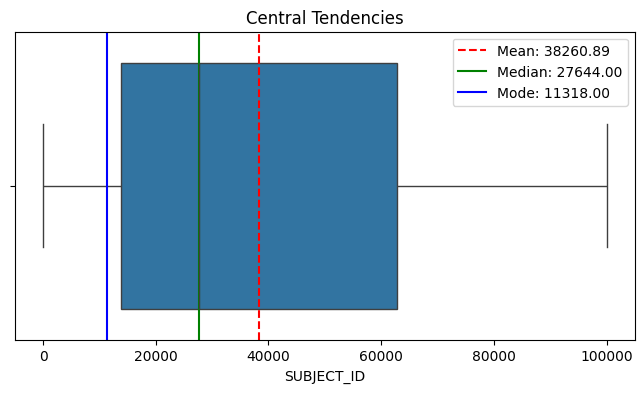

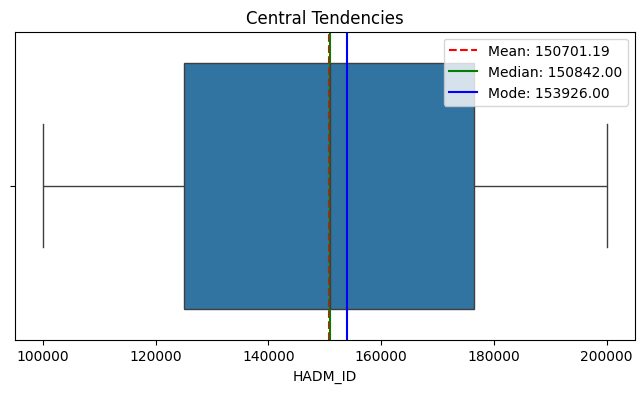

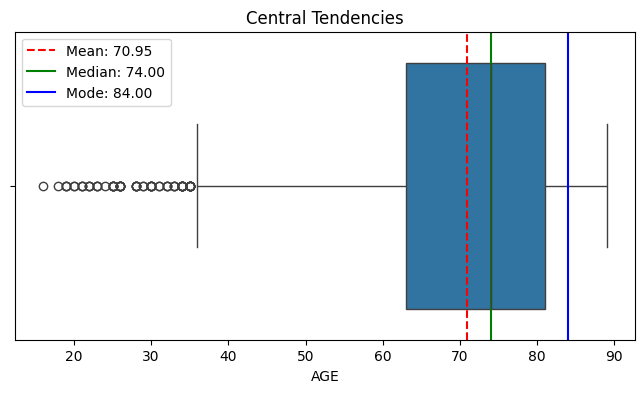

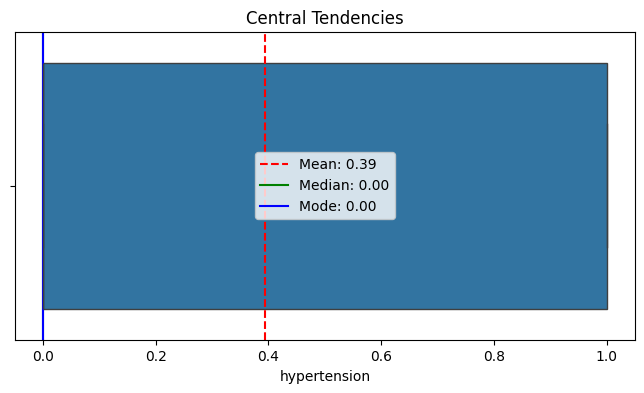

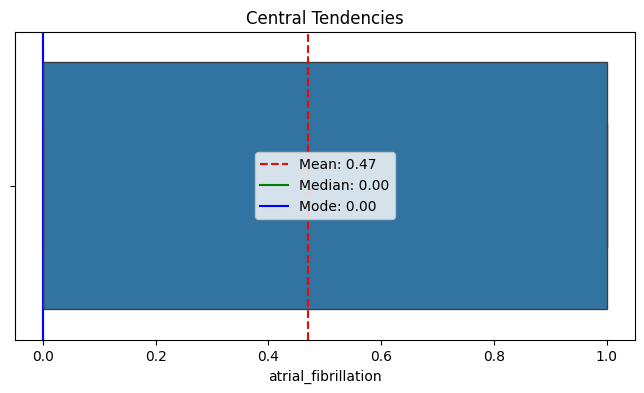

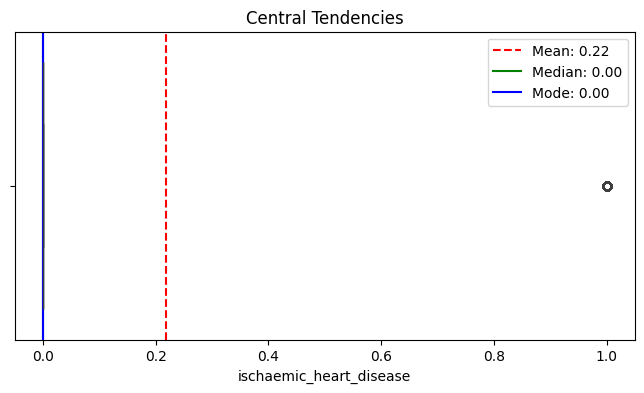

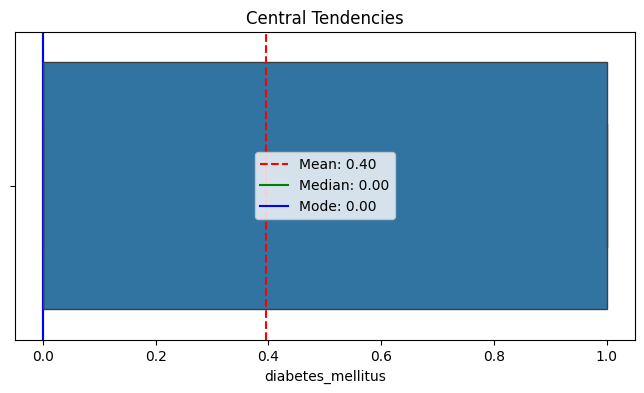

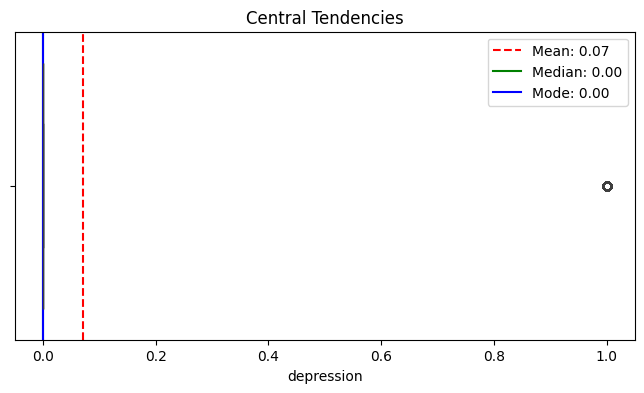

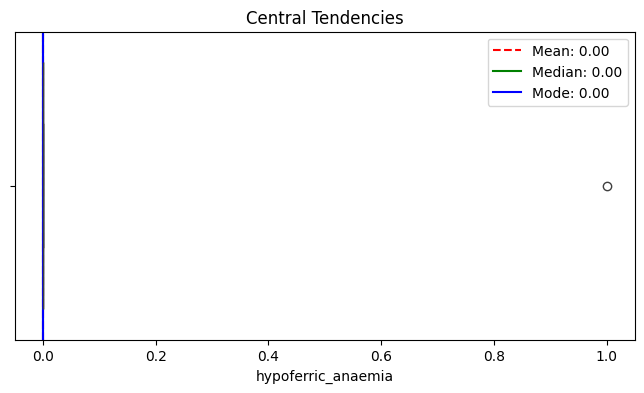

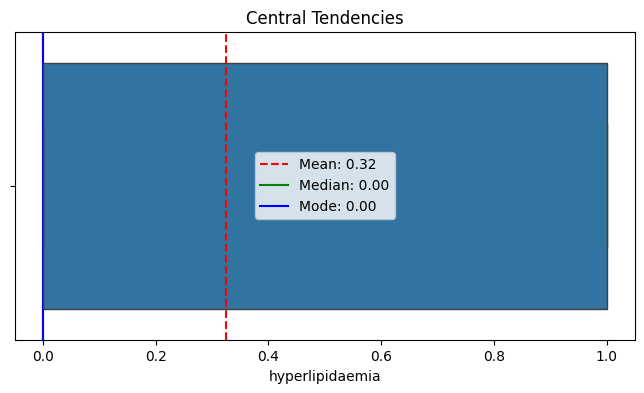

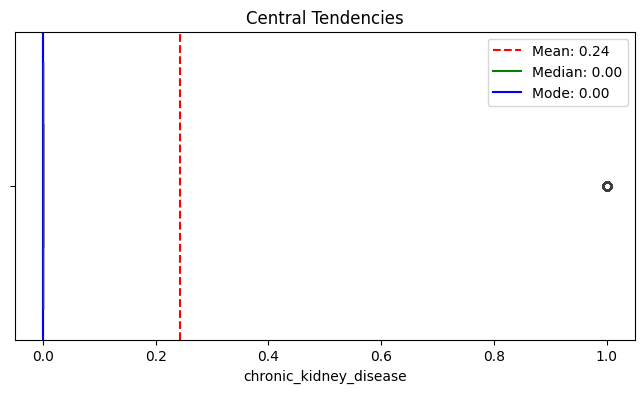

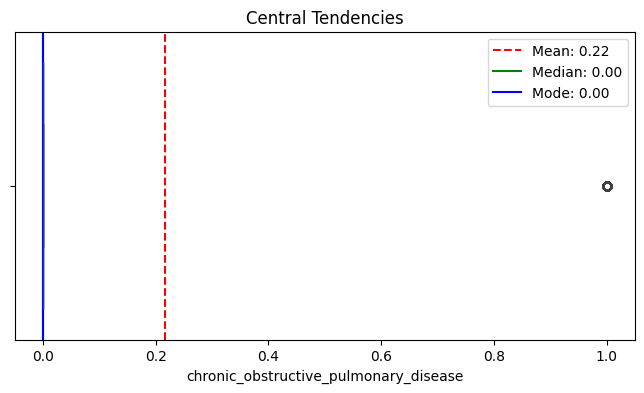

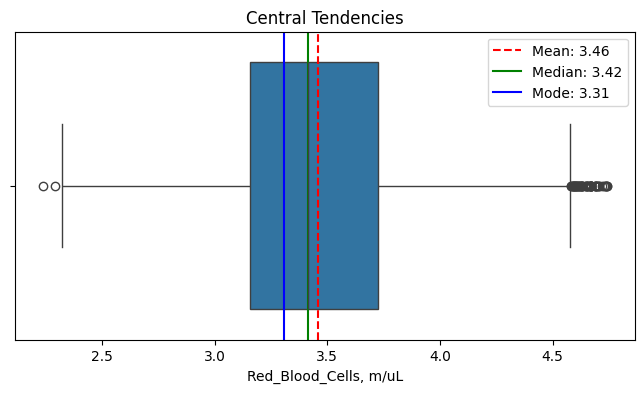

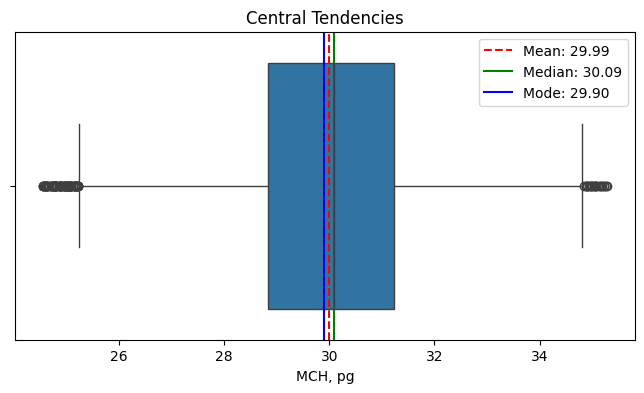

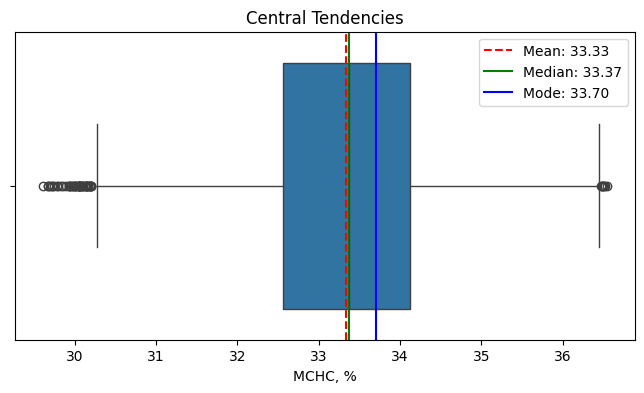

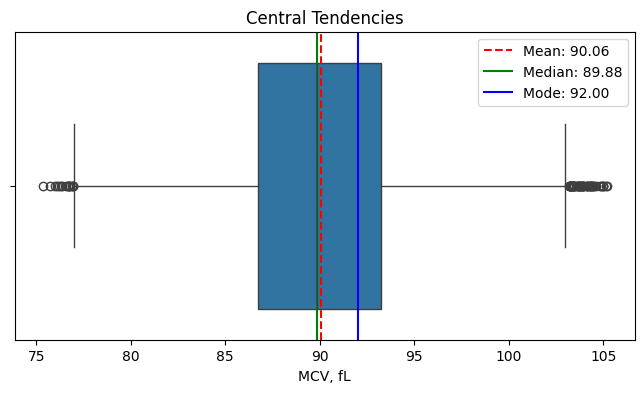

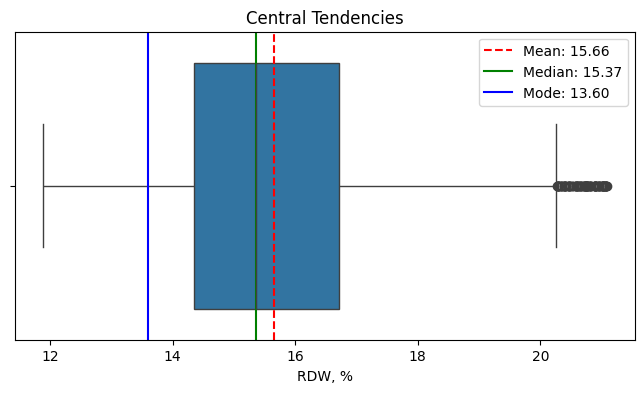

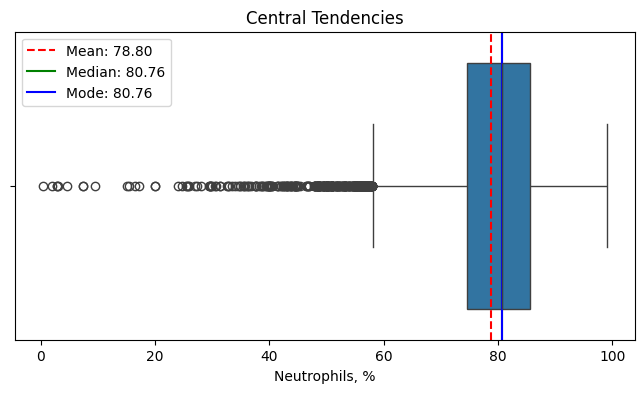

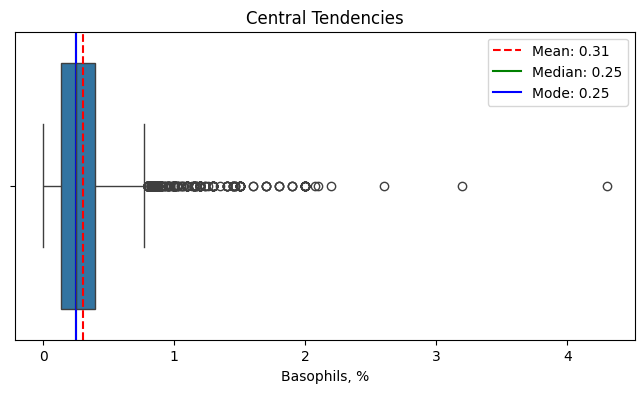

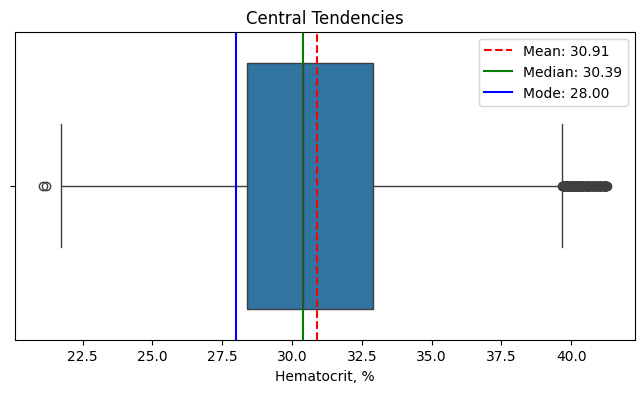

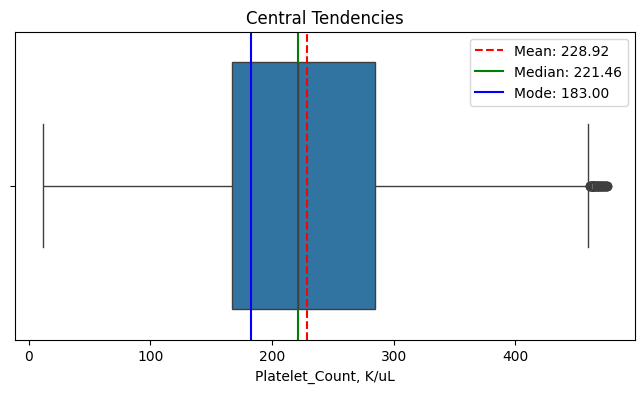

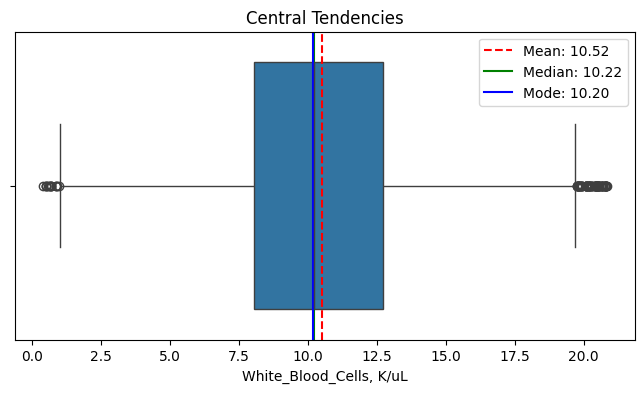

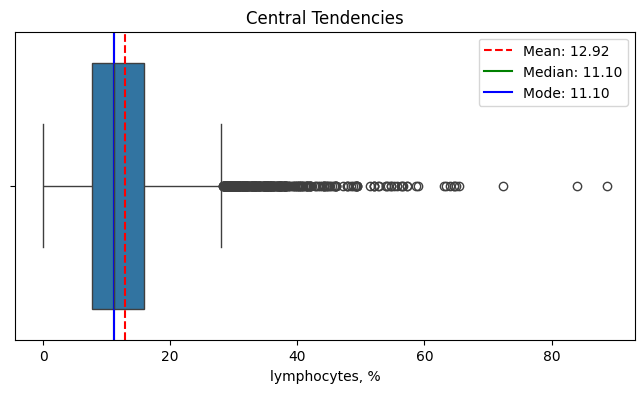

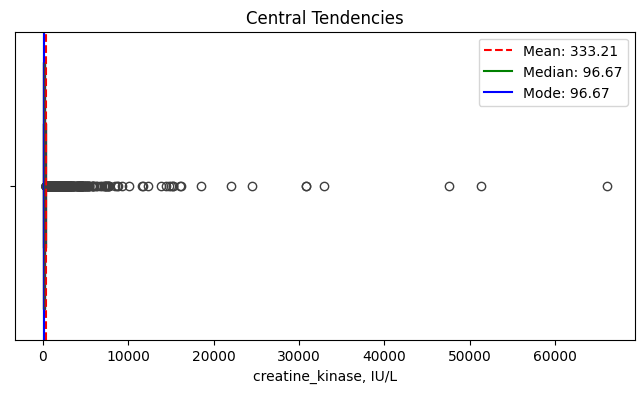

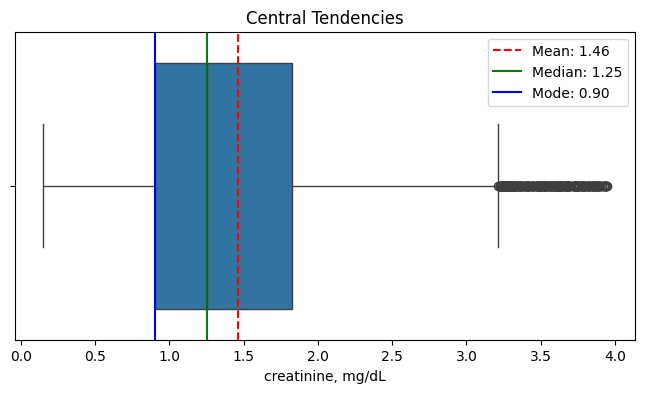

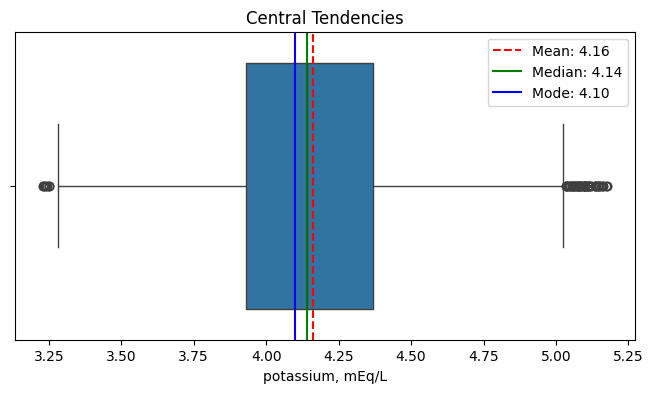

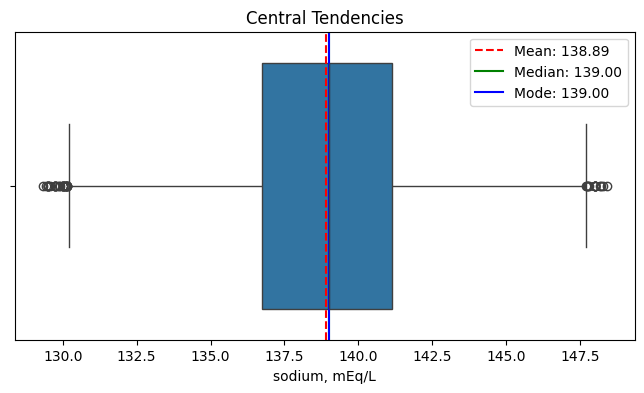

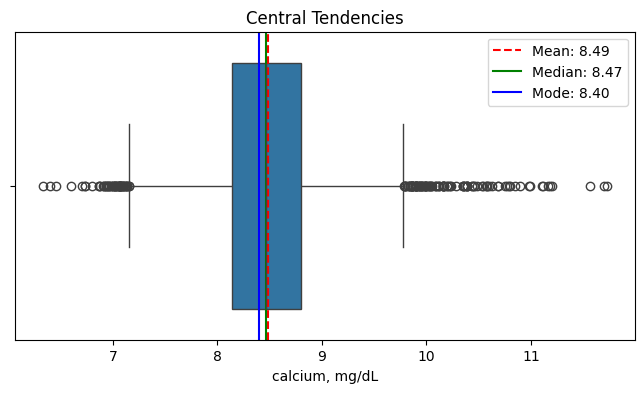

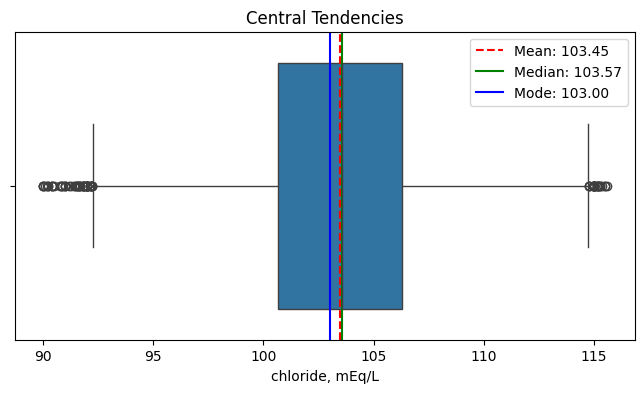

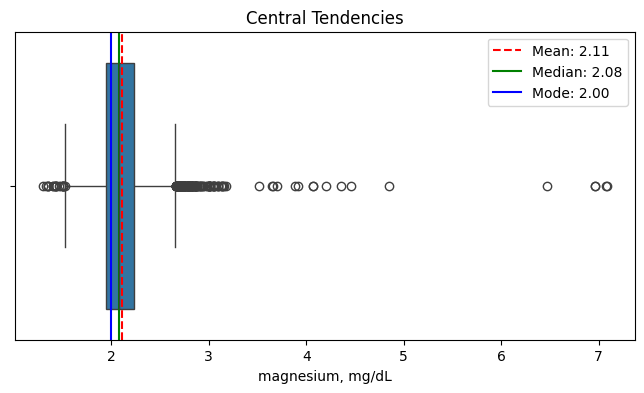

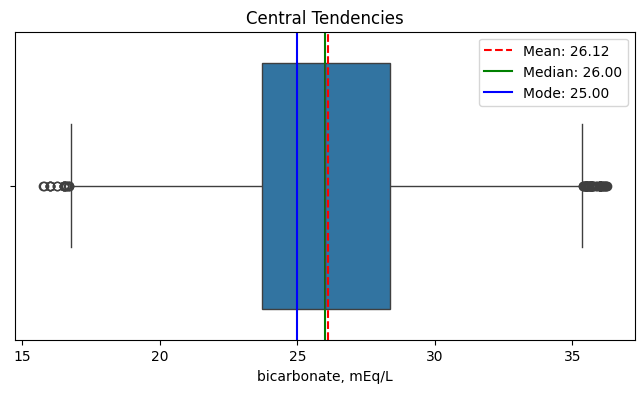

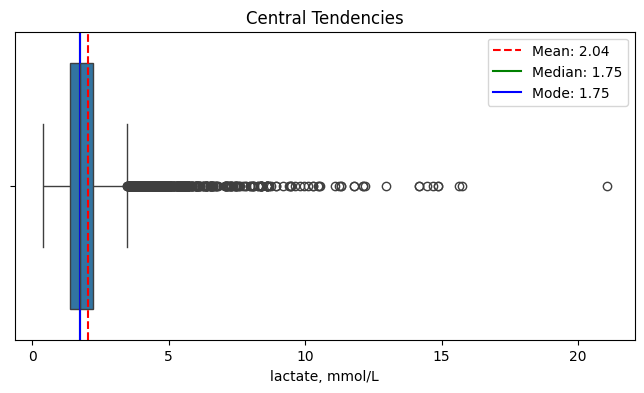

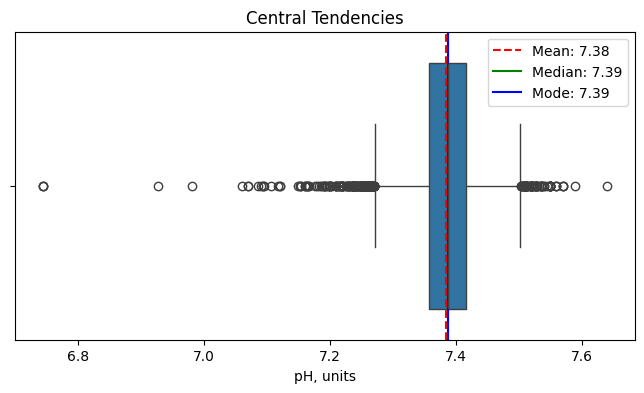

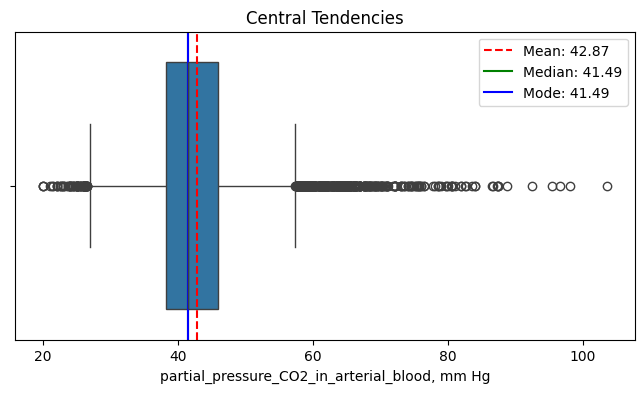

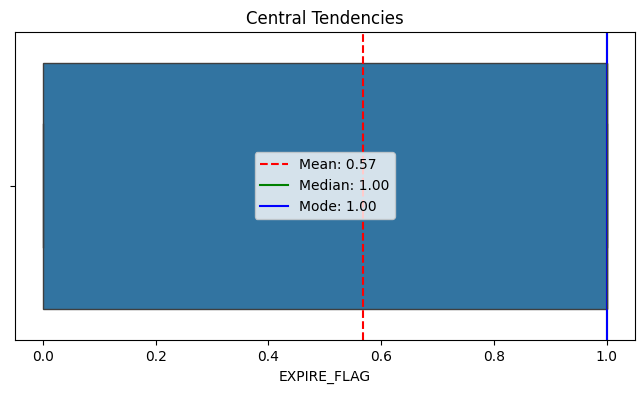

In [ ]:
#I measure center point for better understanding my data distribution
columns_to_exclude = ['GENDER', 'ETHNICITY']
numeric_data = pure_data.drop(columns=columns_to_exclude)

def plot_central_tendencies(df):
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[column])
        plt.title(f'Central Tendencies')

        # Calculations
        mean = df[column].mean()
        median = df[column].median()
        mode = df[column].mode().iloc[0]

        plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
        plt.axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
        plt.axvline(mode, color='b', linestyle='-', label=f'Mode: {mode:.2f}')
        plt.legend()
        plt.show()

plot_central_tendencies(numeric_data)


In [ ]:
label_counts = pure_data['EXPIRE_FLAG'].value_counts()
print(label_counts)

EXPIRE_FLAG
1    4128
0    3152
Name: count, dtype: int64


 The lables are not very imbalaced but we can do som methods to enhance on our traing set.

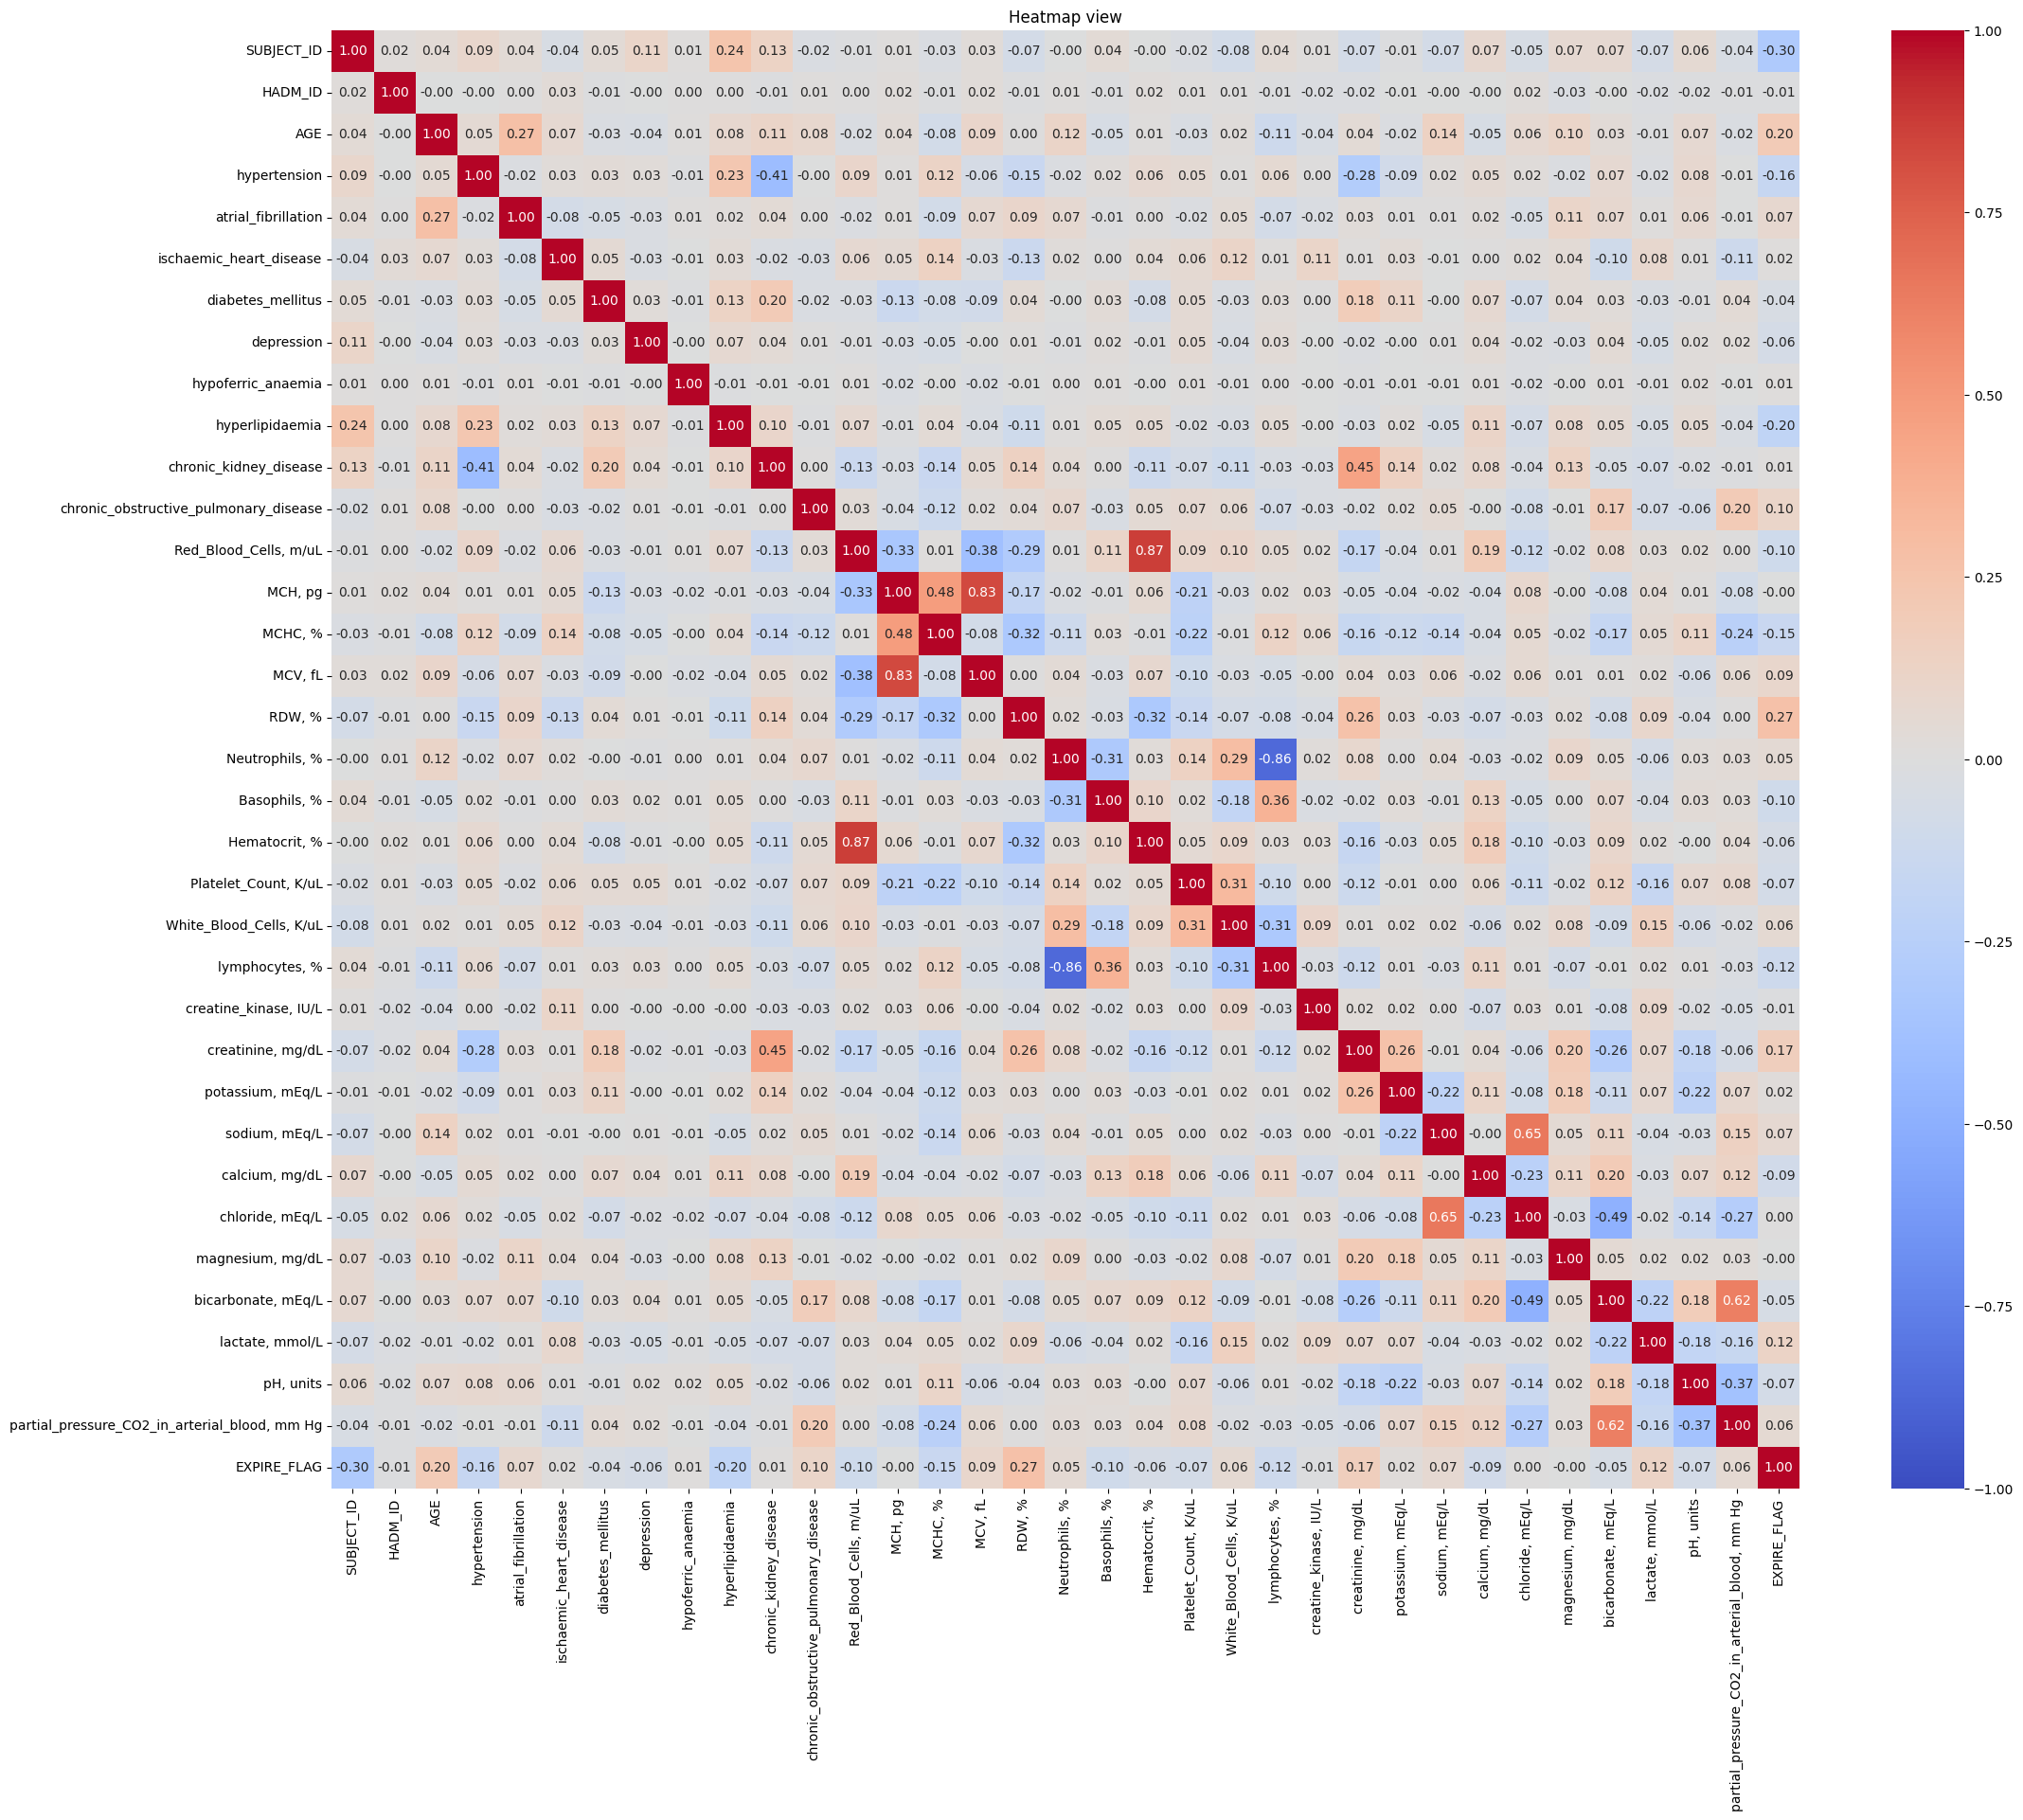

In [ ]:
# correlation matrix

columns_to_removing = ['GENDER', 'ETHNICITY']
data_numerically = pure_data.drop(columns=columns_to_removing)

correlation_mx= data_numerically.corr()

plt.figure(figsize=(25,20))

sns.heatmap(correlation_mx, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Heatmap view")
plt.show()

#plt.savefig("/content/drive/MyDrive/Techniques_of_AI/Final_techniques_of_AI/correlation_matrix.png")




Age Statistics by Mortality (EXPIRE_FLAG):
              count       mean        std   min   25%   50%   75%   max
EXPIRE_FLAG                                                            
0            3152.0  68.124048  12.928587  16.0  60.0  70.0  78.0  89.0
1            4128.0  73.104167  11.292134  22.0  67.0  76.0  82.0  88.0


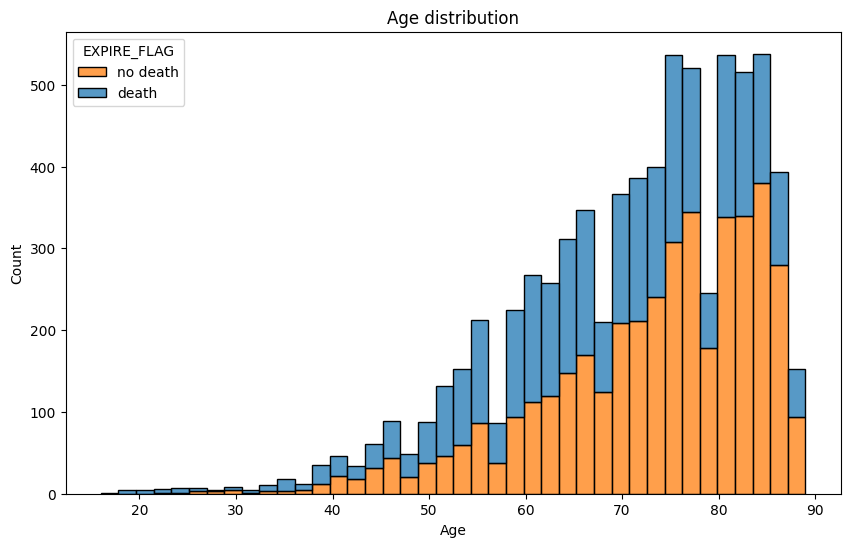

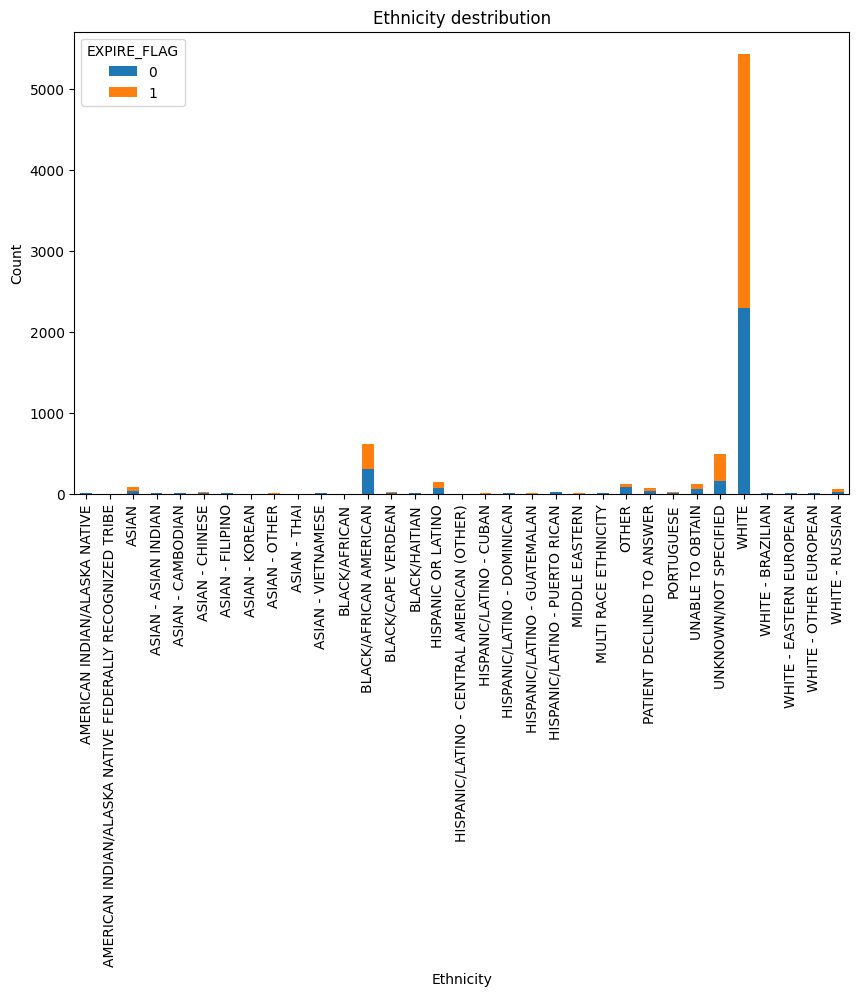

In [ ]:
#visualization of Age and ethnicity - descriptive statistics

age = pure_data.groupby('EXPIRE_FLAG')['AGE'].describe()
print("Age Statistics by Mortality (EXPIRE_FLAG):")
print(age)

# Distribution and count of ethnicity based on EXPIRE_FLAG
ethnicity= pure_data.groupby('EXPIRE_FLAG')['ETHNICITY'].value_counts()


plt.figure(figsize=(10, 6))
sns.histplot(data=pure_data, x='AGE', hue='EXPIRE_FLAG', multiple='stack', bins=40)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='EXPIRE_FLAG', labels=['no death', 'death'])
plt.show()

ethnicity_distributions = pure_data.groupby(['EXPIRE_FLAG', 'ETHNICITY']).size().unstack().T
ethnicity_distributions.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Ethnicity destribution')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.show()


<Figure size 1000x600 with 0 Axes>

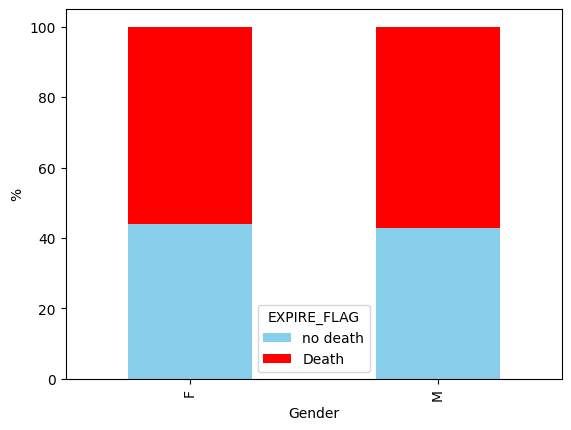

<Figure size 1200x800 with 0 Axes>

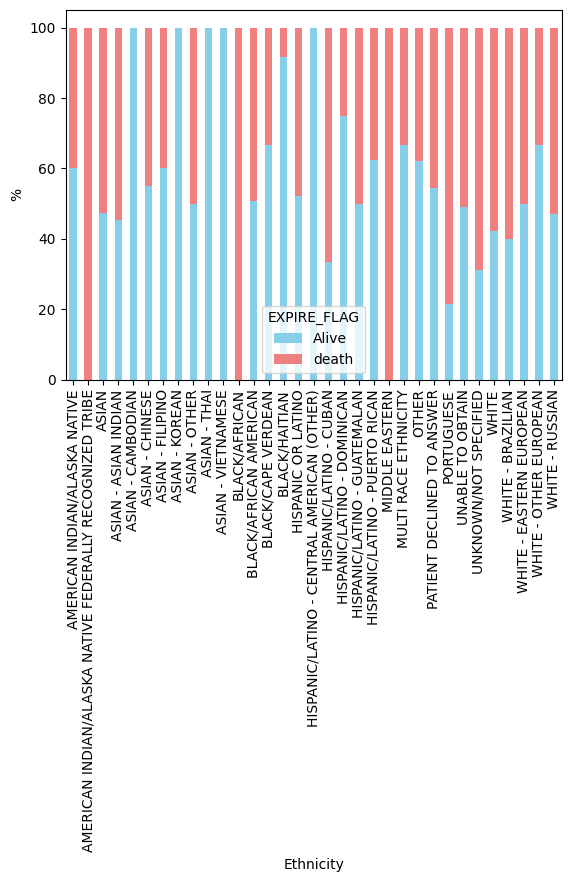

In [ ]:
#see the proportions of death/alive to see the difference in gender
gender = pure_data.groupby(['GENDER', 'EXPIRE_FLAG']).size().unstack().fillna(0)
gender_proportions = gender.div(gender.sum(axis=1), axis=0) * 100

#And for ethnicity
ethnicity= pure_data.groupby(['ETHNICITY', 'EXPIRE_FLAG']).size().unstack().fillna(0)
ethnicity_proportions = ethnicity.div(ethnicity.sum(axis=1), axis=0) * 100


plt.figure(figsize=(10, 6))
gender_proportions.plot(kind='bar', stacked=True, color=['skyblue', 'red'])
plt.xlabel('Gender')
plt.ylabel('%')
plt.legend(title='EXPIRE_FLAG', labels=['no death', 'Death'])
plt.show()


plt.figure(figsize=(12, 8))
ethnicity_proportions.plot(kind='bar', stacked=True, color=['skyblue', 'lightcoral'])
plt.xlabel('Ethnicity')
plt.ylabel('%')
plt.legend(title='EXPIRE_FLAG', labels=['Alive', 'death'])
plt.xticks(rotation=90)
plt.show()


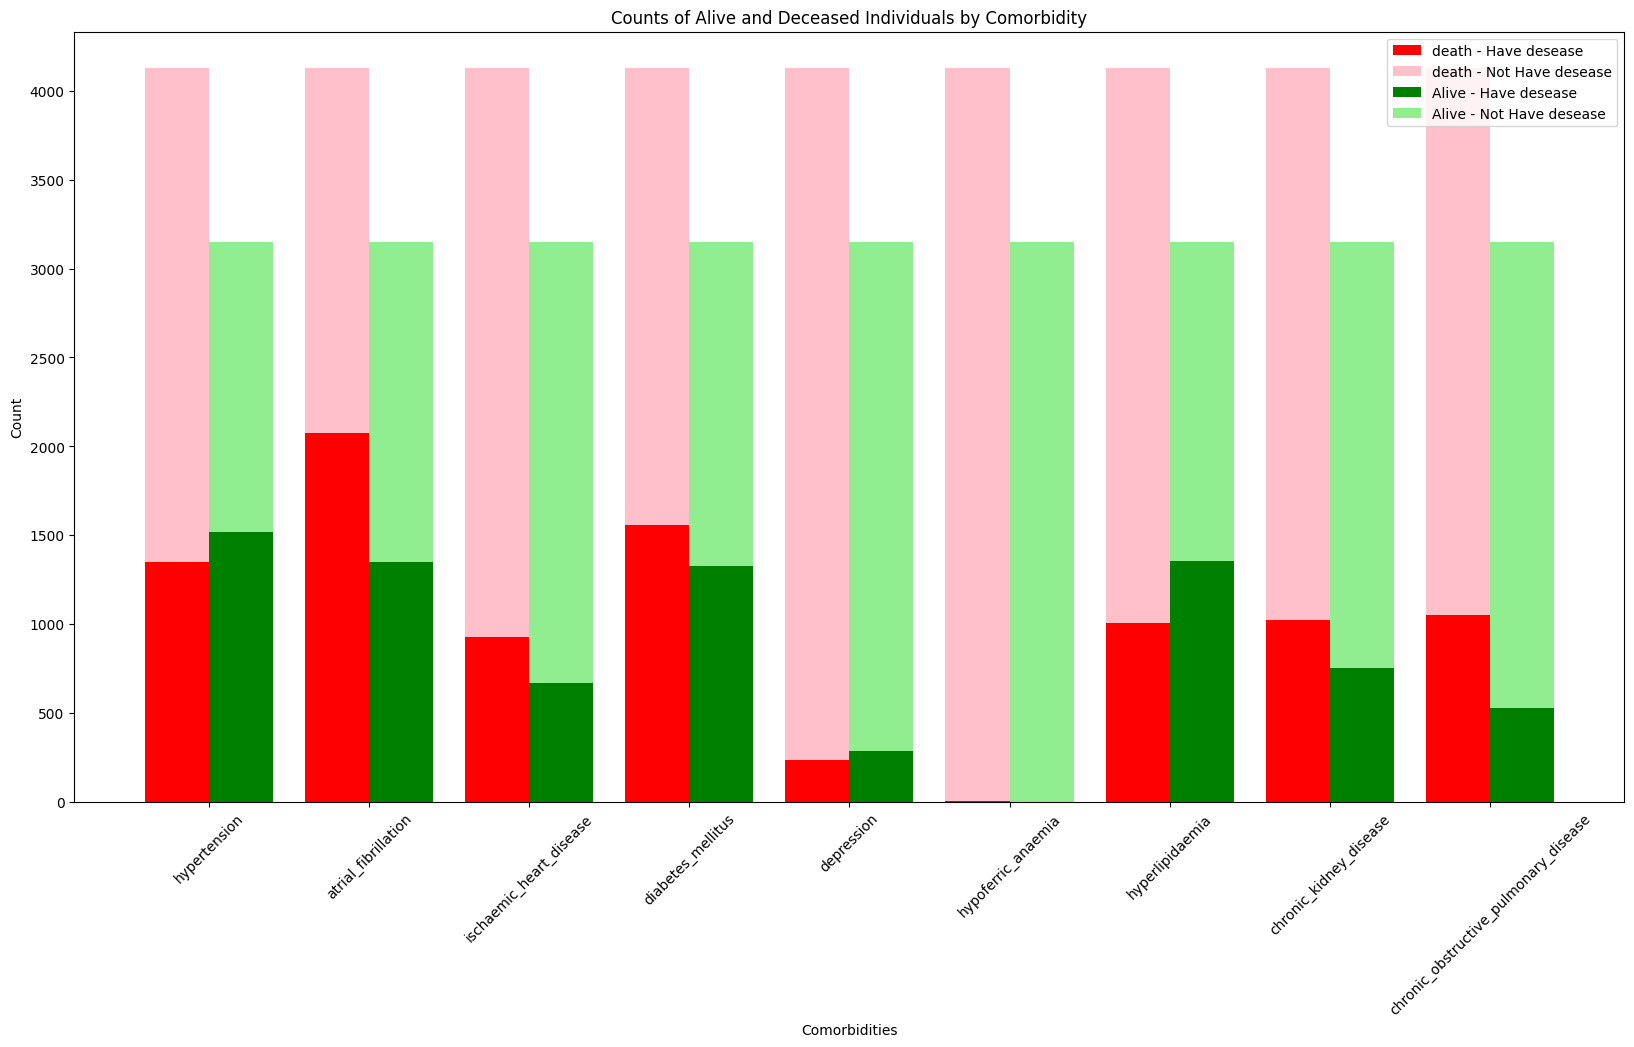

In [ ]:
#patients cormobilities

# to better visualize the cormobilities I analyzed them each by each seperatly,but to show better and more efficient

death_data = pure_data[pure_data['EXPIRE_FLAG'] == 1]
alive_data = pure_data[pure_data['EXPIRE_FLAG'] == 0]

comorbidities = [
    'hypertension', 'atrial_fibrillation', 'ischaemic_heart_disease', 'diabetes_mellitus',
    'depression', 'hypoferric_anaemia', 'hyperlipidaemia', 'chronic_kidney_disease',
    'chronic_obstructive_pulmonary_disease'
]

deceased_counts = [death_data[comorbidity].value_counts() for comorbidity in comorbidities]
alive_counts = [alive_data[comorbidity].value_counts() for comorbidity in comorbidities]

have_deceased = [count[1] if 1 in count else 0 for count in deceased_counts]
not_have_deceased = [count[0] if 0 in count else 0 for count in deceased_counts]
have_alive = [count[1] if 1 in count else 0 for count in alive_counts]
not_have_alive = [count[0] if 0 in count else 0 for count in alive_counts]


x = range(len(comorbidities))
width = 0.4

plt.figure(figsize=(20, 10))


plt.bar(x, have_deceased, width=width, label='death - Have desease', color='red', align='center')
plt.bar(x, not_have_deceased, width=width, bottom=have_deceased, label='death - Not Have desease', color='pink', align='center')

plt.bar([p + width for p in x], have_alive, width=width, label='Alive - Have desease', color='green', align='center')
plt.bar([p + width for p in x], not_have_alive, width=width, bottom=have_alive, label='Alive - Not Have desease', color='lightgreen', align='center')

plt.xticks([p + width/2 for p in x], comorbidities, rotation=45)
plt.title('Counts of Alive and Deceased Individuals by Comorbidity')
plt.xlabel('Comorbidities')
plt.ylabel('Count')
plt.legend()
plt.show()


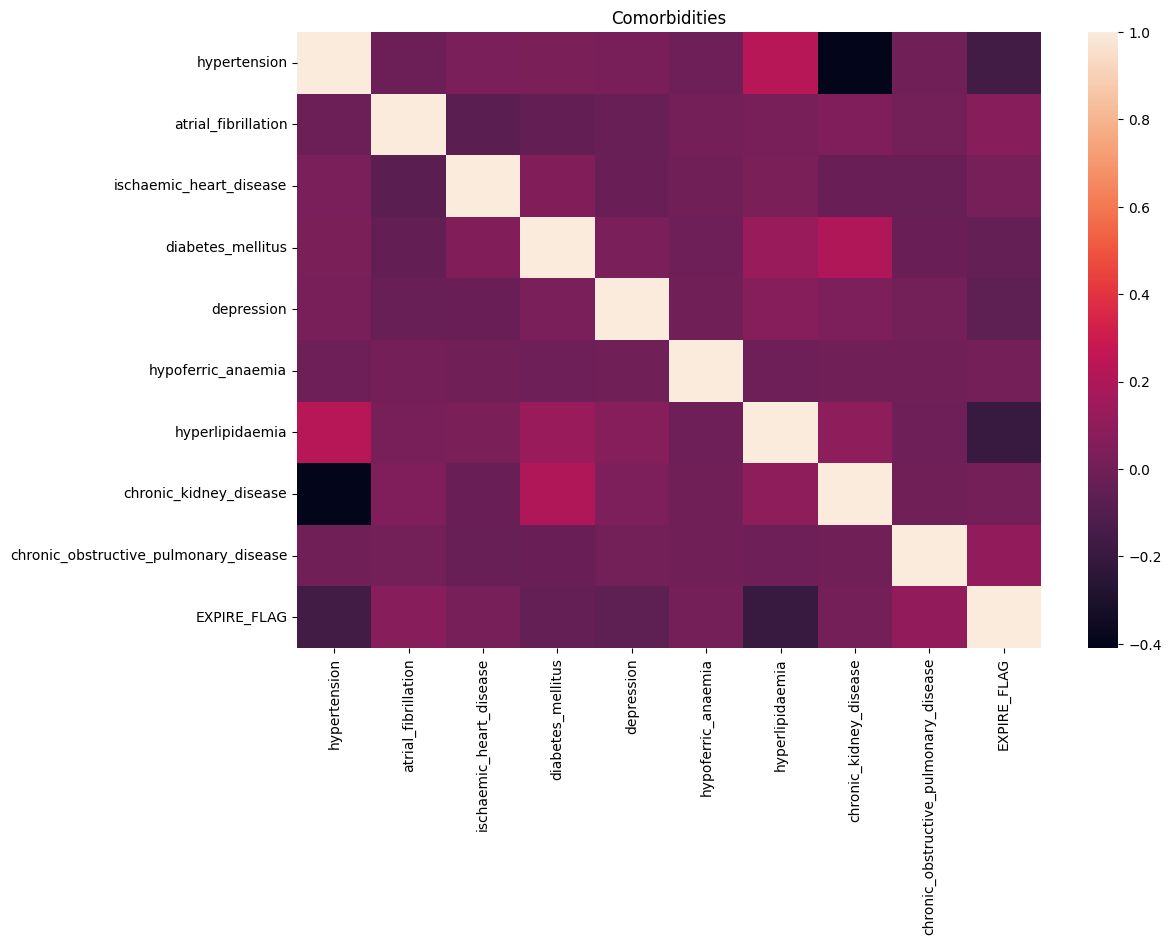

In [ ]:
features = comorbidities + ['EXPIRE_FLAG']
correlation_matrix = pure_data[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix)
plt.title("Comorbidities")
plt.show()


In [ ]:
#vital signs and lab var visualization

vital_lab_vars = [
    'Red_Blood_Cells, m/uL', 'MCH, pg', 'MCHC, %', 'MCV, fL', 'RDW, %', 'Neutrophils, %', 'Basophils, %',
    'Hematocrit, %', 'Platelet_Count, K/uL', 'White_Blood_Cells, K/uL', 'lymphocytes, %', 'creatine_kinase, IU/L',
    'creatinine, mg/dL', 'potassium, mEq/L', 'sodium, mEq/L', 'calcium, mg/dL', 'chloride, mEq/L',
    'magnesium, mg/dL', 'bicarbonate, mEq/L', 'lactate, mmol/L', 'pH, units', 'partial_pressure_CO2_in_arterial_blood, mm Hg'
]




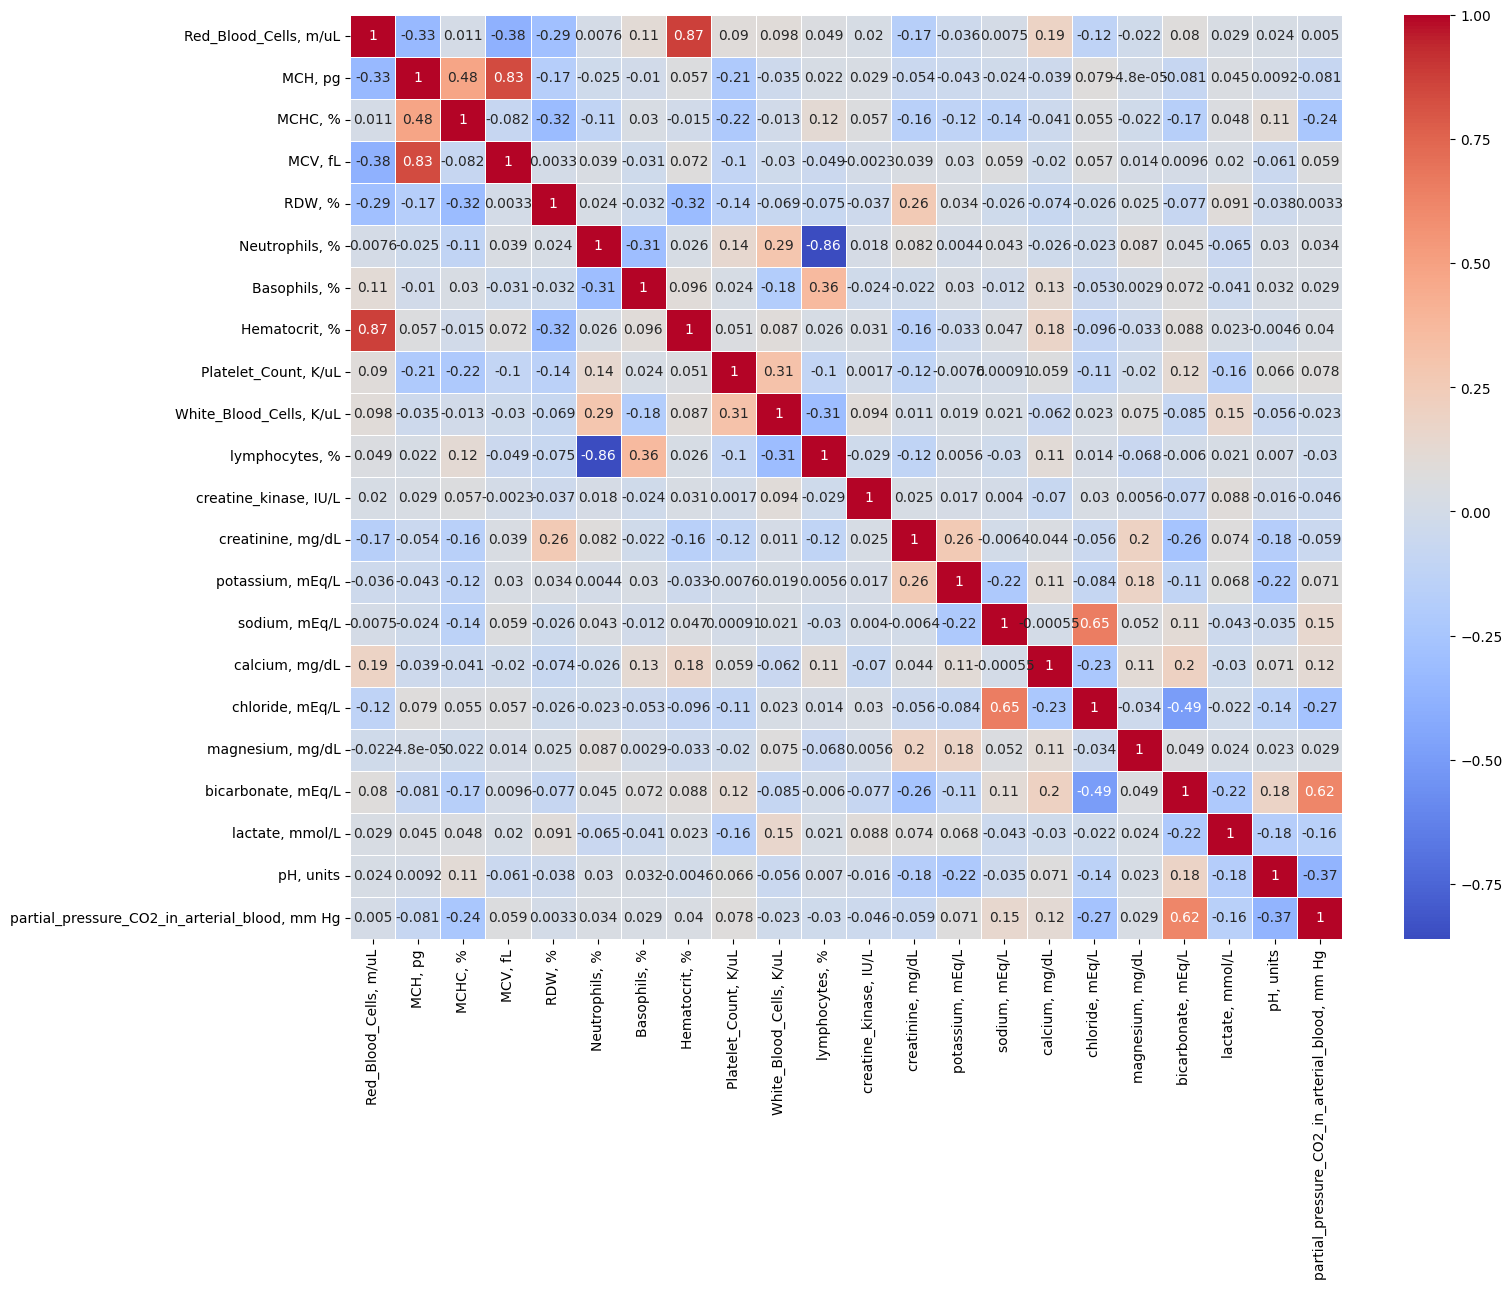

In [ ]:
correlation_matrix = pure_data[vital_lab_vars].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix,annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# Feature selection

I used two methods appropriate to my data set for finding the best features with Random forest and xgboost methods , then I got an average rates from the best to the least important features and choosed the best ones in terms of their value ditances with eachother.

In [ ]:

pure_data = reading_data('Final_preprocessed_data.csv')

In [ ]:
X = pure_data.drop(columns=['GENDER', 'ETHNICITY', 'EXPIRE_FLAG', 'SUBJECT_ID', 'HADM_ID'])
y = pure_data['EXPIRE_FLAG']

# Spliting to 80%,20% as normally done
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

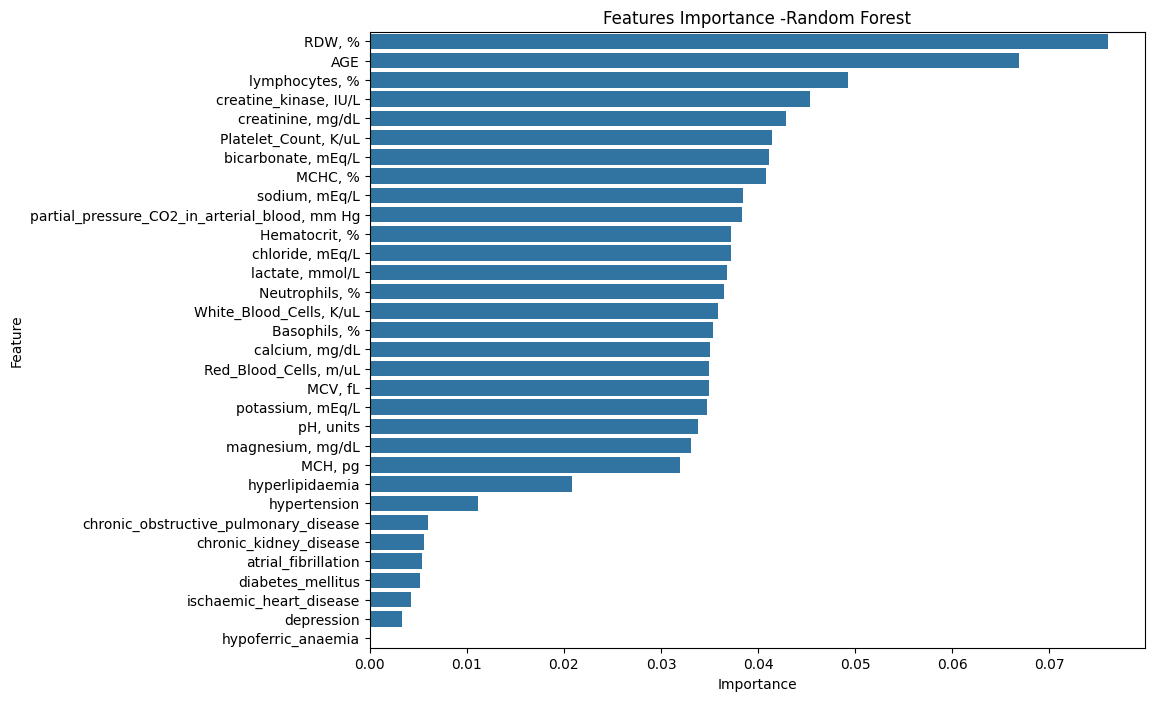

                                          Feature  Importance
14                                         RDW, %    0.076050
0                                             AGE    0.066891
20                                 lymphocytes, %    0.049275
21                          creatine_kinase, IU/L    0.045324
22                              creatinine, mg/dL    0.042900
18                           Platelet_Count, K/uL    0.041433
28                             bicarbonate, mEq/L    0.041129
12                                        MCHC, %    0.040834
24                                  sodium, mEq/L    0.038505
31  partial_pressure_CO2_in_arterial_blood, mm Hg    0.038402
17                                  Hematocrit, %    0.037255
26                                chloride, mEq/L    0.037186
29                                lactate, mmol/L    0.036785
15                                 Neutrophils, %    0.036498
19                        White_Blood_Cells, K/uL    0.035844
16      

In [ ]:
#Random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# scoreing feature importances
importances = rf_model.feature_importances_
features= X.columns

#dtaFrame
important_feature = pd.DataFrame({'Feature': features, 'Importance': importances})
important_feature = important_feature.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=important_feature)
plt.title("Features Importance -Random Forest")
plt.show()

print(important_feature)


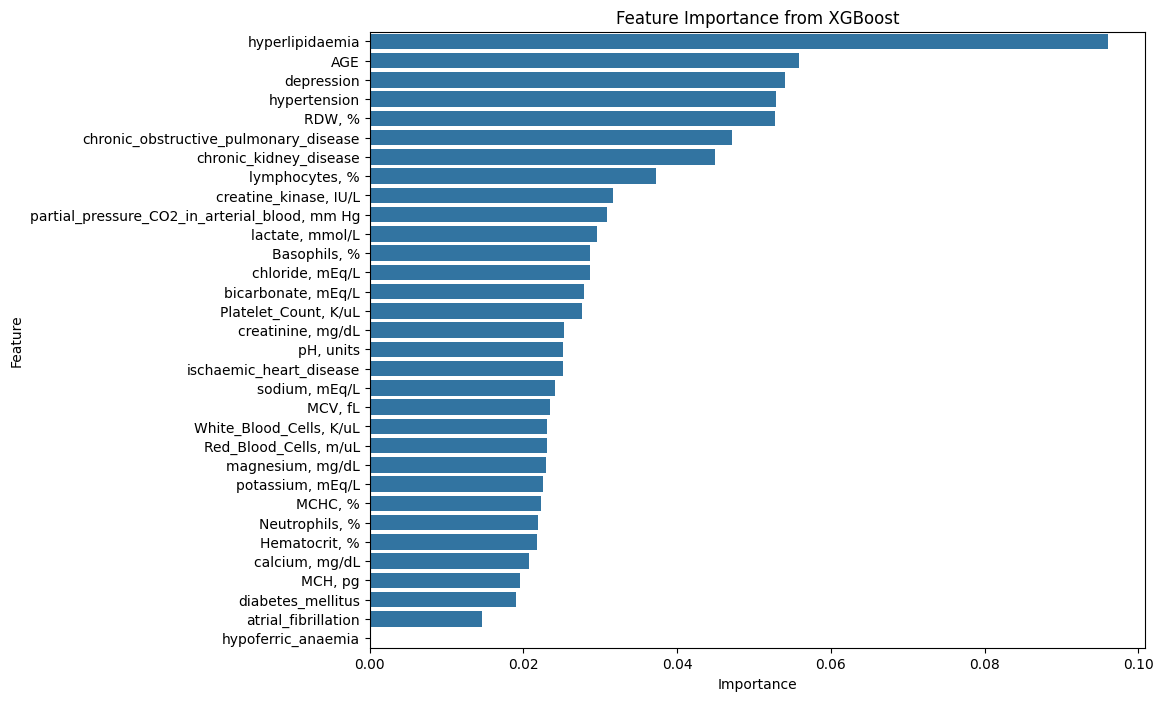

                                          Feature  Importance
7                                 hyperlipidaemia    0.096030
0                                             AGE    0.055890
5                                      depression    0.053960
1                                    hypertension    0.052878
14                                         RDW, %    0.052775
9           chronic_obstructive_pulmonary_disease    0.047079
8                          chronic_kidney_disease    0.044851
20                                 lymphocytes, %    0.037211
21                          creatine_kinase, IU/L    0.031666
31  partial_pressure_CO2_in_arterial_blood, mm Hg    0.030816
29                                lactate, mmol/L    0.029560
16                                   Basophils, %    0.028688
26                                chloride, mEq/L    0.028661
28                             bicarbonate, mEq/L    0.027908
18                           Platelet_Count, K/uL    0.027631
22      

In [ ]:
#xgboosting
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)


importances = xgb_model.feature_importances_
name_the_feature = X.columns
feature_imp = pd.DataFrame({'Feature': name_the_feature, 'Importance': importances})
feature_imp = feature_imp.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title("Feature Importance from XGBoost")
plt.show()
print(feature_imp)



In [ ]:

feature_evaluation = reading_data('merged_features_importance.csv')

In [ ]:
#Combining Multiple Models of feature selection and take an average of them (Ensemble Method)


feature_evaluation['Average_Importance'] = feature_evaluation[['Importance_df1','Importance_df2']].mean(axis=1)

# Sortting them to see from the best to down with lower importance
average = feature_evaluation.sort_values(by='Average_Importance', ascending=False).reset_index(drop=True)
print(average)


                                          Feature  Importance_df1  \
0                                          RDW, %        0.076050   
1                                             AGE        0.066891   
2                                 hyperlipidaemia        0.020836   
3                                  lymphocytes, %        0.049275   
4                           creatine_kinase, IU/L        0.045324   
5   partial_pressure_CO2_in_arterial_blood, mm Hg        0.038402   
6                            Platelet_Count, K/uL        0.041433   
7                              bicarbonate, mEq/L        0.041129   
8                               creatinine, mg/dL        0.042900   
9                                 lactate, mmol/L        0.036785   
10                                chloride, mEq/L        0.037186   
11                                   Basophils, %        0.035349   
12                                   hypertension        0.011145   
13                                

In [ ]:
# Selection of the best features
selected_columns = [
    'SUBJECT_ID', 'HADM_ID', 'RDW, %', 'hyperlipidaemia', 'AGE',
    'chloride, mEq/L', 'chronic_kidney_disease','MCHC, %','White_Blood_Cells, K/uL',
    'bicarbonate, mEq/L', 'creatinine, mg/dL', 'lymphocytes, %','MCV, fL','Neutrophils, %',
    'sodium, mEq/L', 'Basophils, %', 'chronic_obstructive_pulmonary_disease','Hematocrit, %','pH, units',
    'hypertension','creatine_kinase, IU/L','partial_pressure_CO2_in_arterial_blood, mm Hg','Platelet_Count, K/uL','lactate, mmol/L', 'EXPIRE_FLAG'
]


In [ ]:
data_with_feature_selection = pure_data[selected_columns]
#filtered_csv_path = '/content/drive/MyDrive/Techniques_of_AI/Final_techniques_of_AI/data_with_feature_selection.csv'
#data_with_feature_selection.to_csv(filtered_csv_path, index=False)

In [ ]:
data_with_feature_selection.head()

,SUBJECT_ID,HADM_ID,"RDW, %",hyperlipidaemia,AGE,"chloride, mEq/L",chronic_kidney_disease,"MCHC, %","White_Blood_Cells, K/uL","bicarbonate, mEq/L",...,"Basophils, %",chronic_obstructive_pulmonary_disease,"Hematocrit, %","pH, units",hypertension,"creatine_kinase, IU/L","partial_pressure_CO2_in_arterial_blood, mm Hg","Platelet_Count, K/uL","lactate, mmol/L",EXPIRE_FLAG
0,25147,106000,14.600,0,68,107.600,0,35.855,1.834,27.000,...,0.667,0,23.850,7.334,1,58.000,52.929,14.000,2.454,1
1,17863,148295,20.008,0,81,103.000,0,32.197,20.759,22.786,...,0.038,0,28.897,7.378,0,40.545,40.174,262.974,2.268,1
2,19267,117996,16.360,1,80,104.000,1,34.060,15.980,23.500,...,0.100,1,30.025,7.420,0,1728.500,37.667,261.600,1.000,1
3,19334,183582,13.876,0,61,103.455,0,34.979,0.671,25.538,...,0.000,0,26.678,7.322,0,47.500,34.750,34.413,2.633,1
4,19334,155858,16.669,0,60,105.160,0,33.390,11.729,26.500,...,0.117,0,29.565,7.395,0,30.000,45.333,106.466,1.836,1


# modellig

In [ ]:
ready_data = reading_data('data_with_feature_selection.csv')

In [ ]:
data = ready_data.drop(columns=['SUBJECT_ID', 'HADM_ID'])

X = data.drop(columns=['EXPIRE_FLAG'])
y = data['EXPIRE_FLAG']

# test and train seperation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.pipeline import make_pipeline



log_r= make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=1200))
log_r.fit(X_train, y_train)

y_pred = log_r.predict(X_test)

accuracy_l = accuracy_score(y_test, y_pred)*100

log_probability = log_r.predict_proba(X_test)[:, 1]
log_area_under = roc_auc_score(y_test, log_probability)
log_false_p_rate, log_true_p_rat, _ = roc_curve(y_test, log_probability)

c_matrix_l = confusion_matrix(y_test, y_pred)


Accuracy: 71.29 %


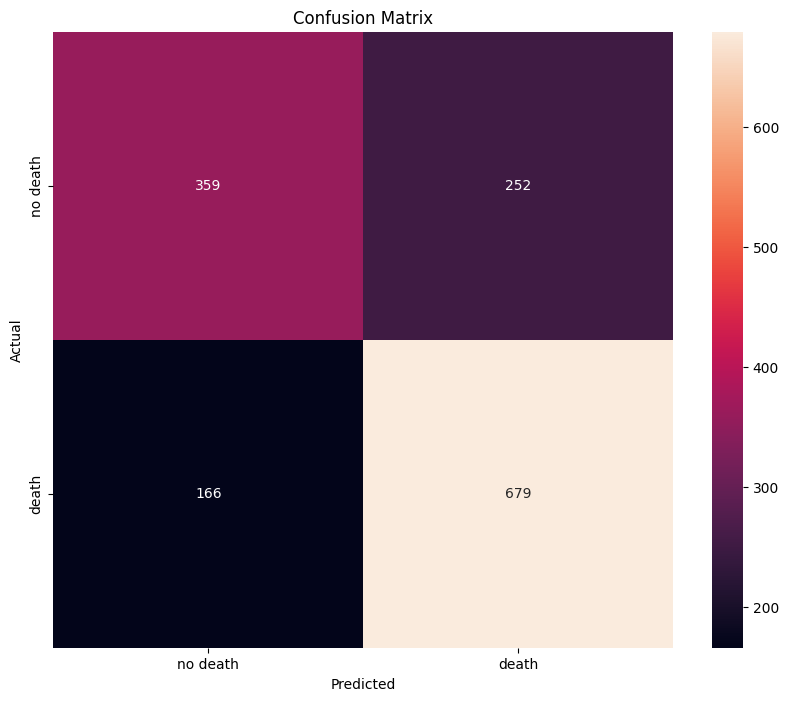

Report:
              precision    recall  f1-score   support

           0       0.68      0.59      0.63       611
           1       0.73      0.80      0.76       845

    accuracy                           0.71      1456
   macro avg       0.71      0.70      0.70      1456
weighted avg       0.71      0.71      0.71      1456



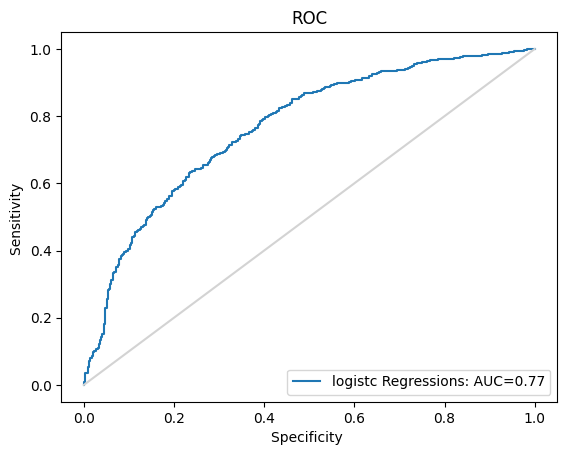

In [ ]:
print(f'Accuracy: {accuracy_l:.2f} %')

plt.figure(figsize=(10, 8))
sns.heatmap(c_matrix_l, annot=True, fmt='d', xticklabels=['no death', 'death'], yticklabels=['no death', 'death'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


class_report_l = classification_report(y_test, y_pred)
print('Report:')
print(class_report_l)


plt.plot(log_false_p_rate, log_true_p_rat, label=f'logistc Regressions: AUC={log_area_under:.2f}')
plt.xlabel('Specificity ')
plt.ylabel('Sensitivity ')
plt.title('ROC')
plt.plot([0, 1], [0, 1], c='lightgrey')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#random forest traing
#I tried with different hyperparameters but I couldnot get a better accuracy
random = RandomForestClassifier()
random.fit(X_train, y_train)

#Prediction
y_pred = random.predict(X_test)

# camparing y predic with y test(accuracy)
accuracy_random = (accuracy_score(y_test, y_pred)*100)

#calculating the probability of the posisitives
random_probability = random.predict_proba(X_test)[:, 1]

random_area_under = roc_auc_score(y_test, random_probability)

random_false_p_rate, random_true_p_rat, _ = roc_curve(y_test, random_probability)


c_matrix_random = confusion_matrix(y_test, y_pred)

accuracy of random forests: 77.88 % 


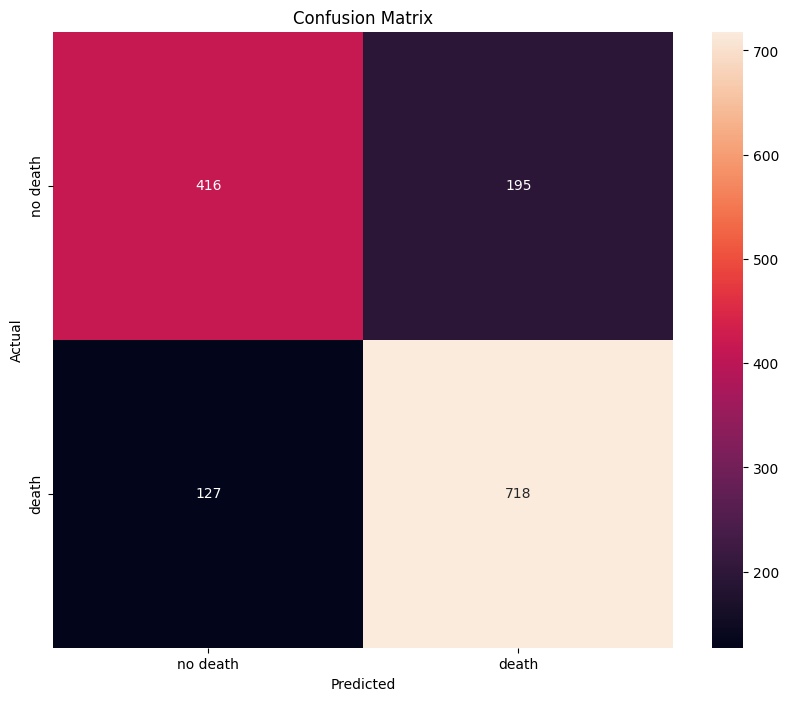

              precision    recall  f1-score   support

           0       0.69      0.64      0.67       611
           1       0.75      0.80      0.77       845

    accuracy                           0.73      1456
   macro avg       0.72      0.72      0.72      1456
weighted avg       0.73      0.73      0.73      1456



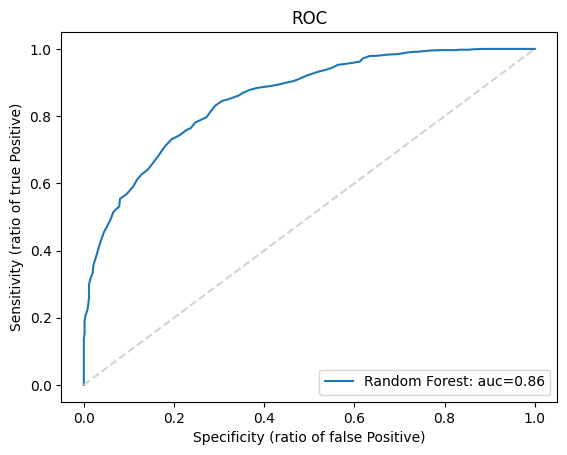

In [ ]:
print(f'accuracy of random forests: {accuracy_random:.2f} % ')
plt.figure(figsize=(10, 8))
sns.heatmap(c_matrix_random, annot=True, fmt='d', xticklabels=['no death', 'death'], yticklabels=['no death', 'death'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_random= classification_report(y_test, y_pred)
print(class_random)

plt.plot(random_false_p_rate, random_true_p_rat, label=f'Random Forest: auc={random_area_under:.2f}')
plt.xlabel('Specificity (ratio of false Positive)')
plt.ylabel('Sensitivity (ratio of true Positive)')
plt.title('ROC')
plt.plot([0, 1], [0, 1], ls='--', c='lightgrey')  # Diagonal line
plt.legend(loc="lower right")
plt.show()


In [ ]:

#Gradient Boosting

gradiant = GradientBoostingClassifier(n_estimators=220, learning_rate=0.09)
gradiant.fit(X_train, y_train)

y_pred = gradiant.predict(X_test)


accuracy_g = accuracy_score(y_test, y_pred)*100

gradiant_probability = gradiant.predict_proba(X_test)[:, 1]
gradiant_area_under = roc_auc_score(y_test, gradiant_probability)
gradiant_false_p_rate, gradiant_true_p_rat, _ = roc_curve(y_test, gradiant_probability)

c_matrix_g = confusion_matrix(y_test, y_pred)



Accuracy: 73.01 % 


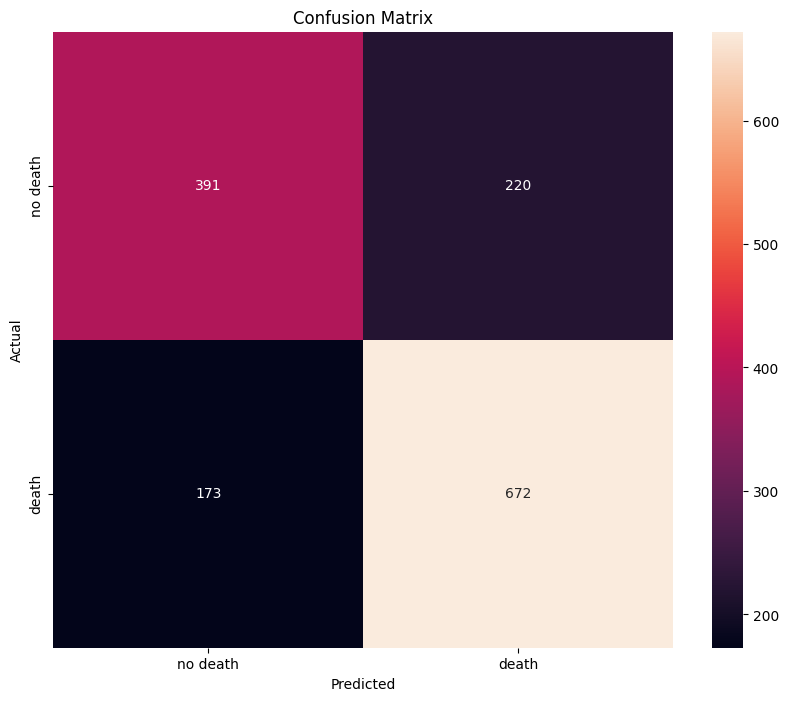

report:
              precision    recall  f1-score   support

           0       0.69      0.64      0.67       611
           1       0.75      0.80      0.77       845

    accuracy                           0.73      1456
   macro avg       0.72      0.72      0.72      1456
weighted avg       0.73      0.73      0.73      1456



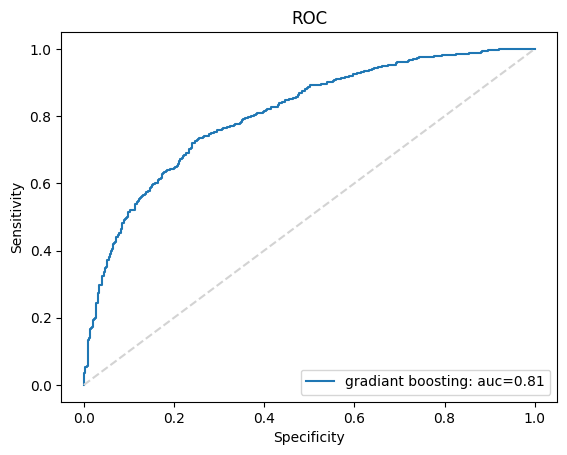

In [ ]:

print(f'Accuracy: {accuracy_g:.2f} % ')

plt.figure(figsize=(10, 8))
sns.heatmap(c_matrix_g, annot=True, fmt='d', xticklabels=['no death', 'death'], yticklabels=['no death', 'death'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_g = classification_report(y_test, y_pred)
print('report:')
print(class_g)


plt.plot(gradiant_false_p_rate, gradiant_true_p_rat, label=f'gradiant boosting: auc={gradiant_area_under:.2f}')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC')
plt.plot([0, 1], [0, 1], ls='--', c='lightgrey')
plt.legend(loc="lower right")
plt.show()


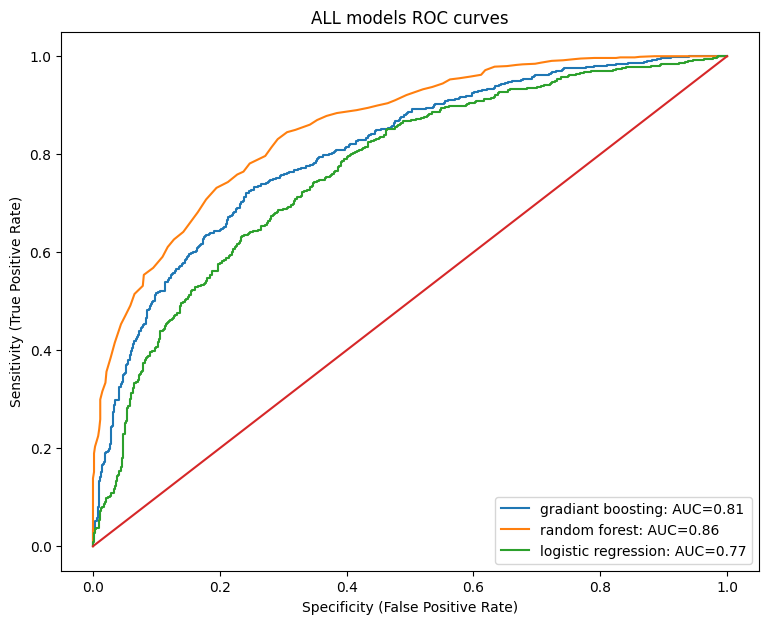

In [ ]:
#for better comparison
plt.figure(figsize=(9, 7))

plt.plot(gradiant_false_p_rate, gradiant_true_p_rat, label=f'gradiant boosting: AUC={gradiant_area_under:.2f}')
plt.plot(random_false_p_rate, random_true_p_rat, label=f'random forest: AUC={random_area_under:.2f}')
plt.plot(log_false_p_rate, log_true_p_rat, label=f'logistic regression: AUC={log_area_under:.2f}')

plt.xlabel('Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ALL models ROC curves')
plt.plot([0, 1], [0, 1])

plt.legend(loc="lower right")
plt.show()

So,after traing the diferent models (I mentioned here just 3 of modells) the best model with the best accuracy of around 78% is Random Forest.

The Random Forest could achieved of 77.88%,so it classify about 78% of the test data.for class 0, 611 instances, 416 were correctly identified, and 195 were incorrectly labeled as class 1. For a positive class,from 845 labels, 718 were correct and 127 were incorrect choosing labeled 0.

For precision,77% of the instances predicted as class 0 were correct. For class 1, the precision is 0.79!it means that 79% predicted for class possitive were correct.In the recall,68% of the actual class 0 examples were found true.For class 1,85% of the actual class 1 instances  were found right.The F1-scores show better function of the modell on the positive class ,0.72 for class 0 and 0.82 for class 1.